In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# **Importing Data**

In [5]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

**Setting Pandas and Seaborn**

In [6]:
pd.set_option("display.max.columns",None)
sns.set(style = 'whitegrid', context = 'paper', font_scale = 1.3, palette = 'deep')

# **Understanding of Data**

In [7]:
print('Train Dataset Shape: ', train.shape)
print('Test Dataset Shape: ', test.shape)

Train Dataset Shape:  (1460, 81)
Test Dataset Shape:  (1459, 80)


In [8]:
train.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 81 entries, Id to SalePrice
dtypes: float64(3), int64(35), object(43)
memory usage: 924.0+ KB


**Descriptive Statistics of Categorical and Numerical Variables**

In [9]:
train.describe(include = 'object')

MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1460   1460    91     1460        1460      1460      1460   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       1151   1454    50      925        1311      1459      1052   

       LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
count       1460         1460       1460       1460     1460       1460   
unique         3           25          9          8        5          8   
top          Gtl        NAmes       Norm       Norm     1Fam     1Story   
freq        1382          225       1260       1445     1220        726   

       RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual  \
count       1460     1460        1460        1460       1452      1460   
unique         6        8          15          16          4         4   
top        Gable  CompShg     VinylSd     VinylSd       None        TA   
freq        1141     1434         515         504        864       906   

       ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
count       1460       1460     1423     1423         1422         1423   
unique         5          6        4        4            4            6   
top           TA      PConc       TA       TA           No          Unf   
freq        1282        647      649     1311          953          430   

       BsmtFinType2 Heating HeatingQC CentralAir Electrical KitchenQual  \
count          1422    1460      1460       1460       1459        1460   
unique            6       6         5          2          5           4   
top             Unf    GasA        Ex          Y      SBrkr          TA   
freq           1256    1428       741       1365       1334         735   

       Functional FireplaceQu GarageType GarageFinish GarageQual GarageCond  \
count        1460         770       1379         1379       1379       1379   
unique          7           5          6            3          5          5   
top           Typ          Gd     Attchd          Unf         TA         TA   
freq         1360         380        870          605       1311       1326   

       PavedDrive PoolQC  Fence MiscFeature SaleType SaleCondition  
count        1460      7    281          54     1460          1460  
unique          3      3      4           4        9             6  
top             Y     Gd  MnPrv        Shed       WD        Normal  
freq         1340      3    157          49     1267          1198

* Neighborhood, Exterior1st, Exterior2nd has decent cardinality
* Alley, FireplaceQu, PollQc, Fence, and MiscFeature has high number of missing value (Often NaN is solo category)

In [10]:
train.describe(include = np.number)

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean     46.549315   567.240411  1057.429452  1162.626712   346.992466   
std     161.319273   441.866955   438.705324   386.587738   436.528436   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   223.000000   795.750000   882.000000     0.000000   
50%       0.000000   477.500000   991.500000  1087.000000     0.000000   
75%       0.000000   808.000000  1298.250000  1391.250000   728.000000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000   
mean       5.844521  1515.463699      0.425342      0.057534     1.565068   
std       48.623081   525.480383      0.518911      0.238753     0.550916   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1129.500000      0.000000      0.000000     1.000000   
50%        0.000000  1464.000000      0.000000      0.000000     2.000000   
75%        0.000000  1776.750000      1.000000      0.000000     2.000000   
max      572.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1460.000000   1460.000000   1460.000000   1460.000000  1460.000000   
mean      0.382877      2.866438      1.046575      6.517808     0.613014   
std       0.502885      0.815778      0.220338      1.625393     0.644666   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     14.000000     3.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1379.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean   1978.506164     1.767123   472.980137    94.244521    46.660274   
std      24.689725     0.747315   213.804841   125.338794    66.256028   
min    1900.000000     0.000000     0.000000     0.000000     0.000000   
25%    1961.000000     1.000000   334.500000     0.000000     0.000000   
50%    1980.000000     2.000000   480.000000     0.000000    25.000000   
75%    2002.000000     2.000000   576.000000   168.000000    68.000000   
max    2

* Some numerical variables (LotArea, MasVnrArea, BsmtFinSF, ...) have high standard deviation due to outliers

In [11]:
test_id = test['Id'] #storing Id of test set for submission file
train.drop(columns="Id",inplace=True)
test.drop(columns="Id",inplace=True)

# **Handling Missing Values**

**Finding Variables with at least 50 % of Missing Values**

In [12]:
nan_df = round(train.isna().sum()/len(train)*100,2).sort_values().to_frame().rename(columns = {0 : 'train'})
nan_df["test"] = round(test.isna().sum()/len(train)*100,2)
nan_df[(nan_df['train'] >= 50) | (nan_df['test'] >= 50)]

train   test
FireplaceQu  47.26  50.00
Fence        80.75  80.07
Alley        93.77  92.60
MiscFeature  96.30  96.44
PoolQC       99.52  99.73

Variables with large number of missing values could lead to bad results. So I will drop them.

In [13]:
nan_cols = ['FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']
train.drop(columns=nan_cols,inplace=True)
test.drop(columns=nan_cols,inplace=True)

**Finding All Missing Values in Train and Test Datasets**

In [14]:
nan_df = train.isna().sum()[train.isna().sum() > 0].sort_values().to_frame().rename(columns = {0 : 'Train Total NaN'})
nan_df['Train %'] = round((train.isna().sum()) / len(train) * 100, 2)
nan_df['Test Total NaN'] = round(test.isna().sum()[test.isna().sum() > 0]).astype('int')
nan_df['Test %'] = round((test.isna().sum()) / len(test) * 100, 2)
nan_df['Types'] = train[nan_df.index.tolist()].dtypes
nan_df

Train Total NaN  Train %  Test Total NaN  Test %    Types
Electrical                  1     0.07             NaN    0.00   object
MasVnrType                  8     0.55            16.0    1.10   object
MasVnrArea                  8     0.55            15.0    1.03  float64
BsmtQual                   37     2.53            44.0    3.02   object
BsmtCond                   37     2.53            45.0    3.08   object
BsmtFinType1               37     2.53            42.0    2.88   object
BsmtExposure               38     2.60            44.0    3.02   object
BsmtFinType2               38     2.60            42.0    2.88   object
GarageType                 81     5.55            76.0    5.21   object
GarageYrBlt                81     5.55            78.0    5.35  float64
GarageFinish               81     5.55            78.0    5.35   object
GarageQual                 81     5.55            78.0    5.35   object
GarageCond                 81     5.55            78.0    5.35   object
LotFrontage               259    17.74           227.0   15.56  float64

**Masonry Veneer and Electrical Columns Filling**

In [15]:
train['MasVnrType'] = train['MasVnrType'].fillna('None')
test['MasVnrType'] = test['MasVnrType'].fillna('None')

train['MasVnrArea'] = train['MasVnrArea'].fillna(train['MasVnrArea'].median(skipna = True))
test['MasVnrArea'] = test['MasVnrArea'].fillna(train['MasVnrArea'].median(skipna = True))

train['Electrical'] = train['Electrical'].fillna('SBrkr')

**Basement and Garage Columns Filling**

In [16]:
for col in ['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtExposure', 'BsmtFinType2']:
    train[col] = train[col].fillna('Na')
    test[col] = test[col].fillna('Na')

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train[col] = train[col].fillna('Na')
    test[col] = test[col].fillna('Na')

train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0)

train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].median(skipna = True))
test['LotFrontage'] = test['LotFrontage'].fillna(train['LotFrontage'].median(skipna = True))

In [17]:
print('Train missing values:', train.isna().sum().sum())
print('Test missing values:', test.isna().sum().sum())

Train missing values: 0
Test missing values: 22


**Checking for Another Missing Values in Test Dataset**

In [18]:
nan_df = test.isna().sum()[test.isna().sum() > 0].sort_values().to_frame().rename(columns = {0 : 'Test Total NaN'})
nan_df['Test %'] = round((test.isna().sum()) / len(test) * 100, 2)
nan_df['Types'] = test[nan_df.index.tolist()].dtypes
nan_df

Test Total NaN  Test %    Types
Exterior1st                1    0.07   object
Exterior2nd                1    0.07   object
BsmtFinSF1                 1    0.07  float64
BsmtFinSF2                 1    0.07  float64
BsmtUnfSF                  1    0.07  float64
TotalBsmtSF                1    0.07  float64
KitchenQual                1    0.07   object
GarageCars                 1    0.07  float64
GarageArea                 1    0.07  float64
SaleType                   1    0.07   object
Utilities                  2    0.14   object
BsmtFullBath               2    0.14  float64
BsmtHalfBath               2    0.14  float64
Functional                 2    0.14   object
MSZoning                   4    0.27   object

* numerical: BsmtFinSF1 (0), BsmtFinSF2 (0), BsmtUnfSF (0), TotalBsmtSF (0), GarageCars (0), GarageArea (0), BsmtFullBath (0),BsmtHalfBath (0)
* categorical: Exterior1st (mode), Exterior2nd (mode), KitchenQual (mode), SaleType (mode), Utilities (mode), Functional (mode), MSZoning (mode)

**Numerical Variables Filling**

In [19]:
num_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'BsmtFullBath', 'BsmtHalfBath']
test[num_cols] = test[num_cols].fillna(0)

**Categorical Variables Filling**

In [20]:
from sklearn.impute import SimpleImputer
cat_cols = ['Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType', 'Utilities', 'Functional', 'MSZoning']

imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(train[cat_cols])
test[cat_cols] = imputer.transform(test[cat_cols])

print('Train missing values:', train.isna().sum().sum())
print('Test missing values:', test.isna().sum().sum())

Train missing values: 0
Test missing values: 0


# **Exploratory Data Analysis**

## **Checking Target Variable**

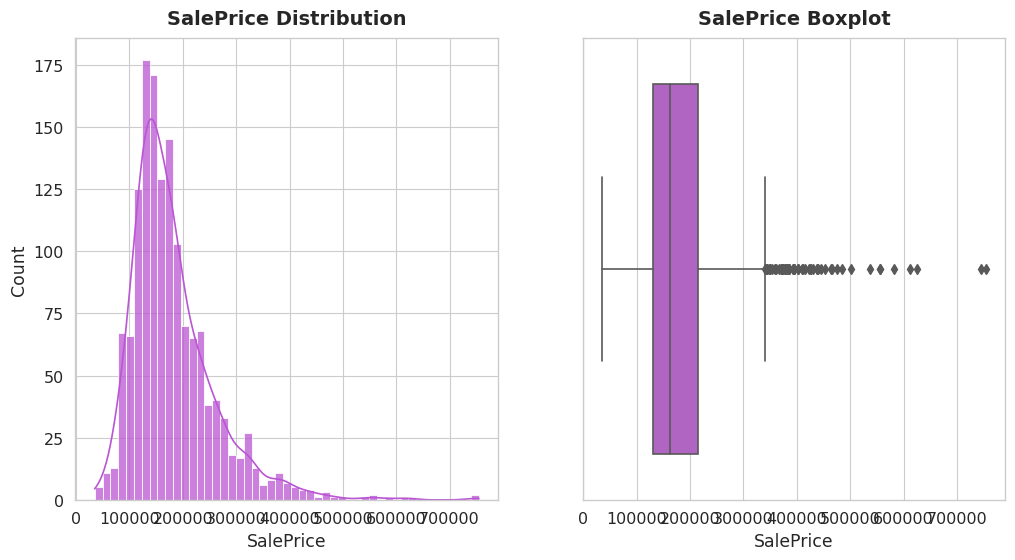

In [21]:
plt.figure(figsize = (12,6))

plt.subplot(1, 2, 1)
sns.histplot(x = train["SalePrice"], color = "mediumorchid", kde = True, alpha = 0.75)
plt.title("SalePrice Distribution",fontweight = "black",pad = 10,size = 14)

plt.subplot(1, 2, 2)
sns.boxplot(x = train["SalePrice"],color = "mediumorchid")
plt.title("SalePrice Boxplot",fontweight = "black",pad = 10,size = 14)
plt.show()

* Target variable is right_skewed due to high number of positive outliers.
* Thus SalePrice should be transformed. I chose logaritmic transformation.

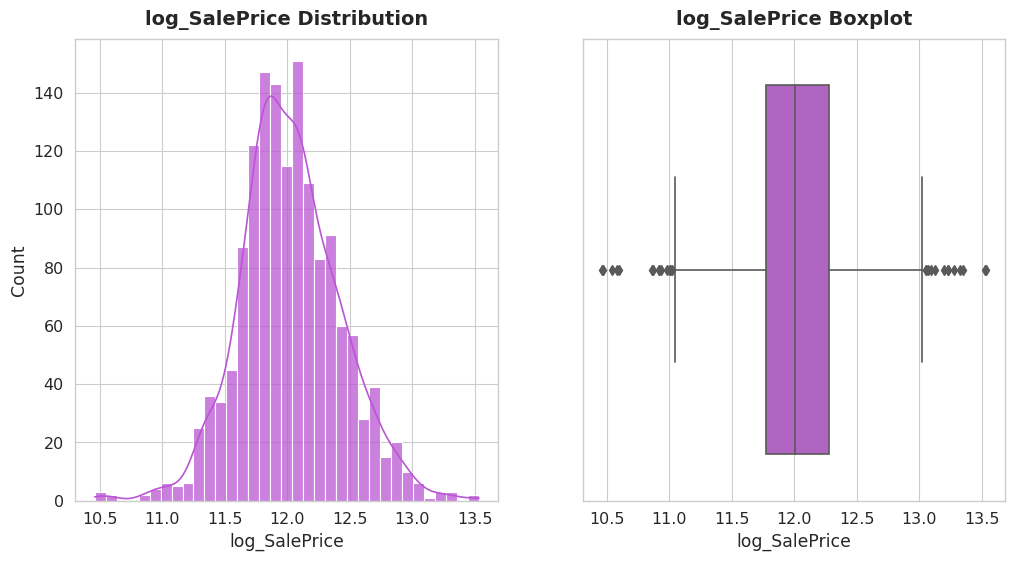

In [22]:
train['log_SalePrice'] = np.log(train['SalePrice'])

plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
sns.histplot(x = train["log_SalePrice"], color = "mediumorchid", kde = True, alpha = 0.75)
plt.title("log_SalePrice Distribution",fontweight = "black",pad = 10,size = 14)

plt.subplot(1,2,2)
sns.boxplot(x = train["log_SalePrice"],color = "mediumorchid")
plt.title("log_SalePrice Boxplot",fontweight = "black",pad = 10,size = 14)
plt.show()

* logaritmic transformation helped with skewness. Outliers are now on both sides of distribution.

## **Exploring Continous Variables** 

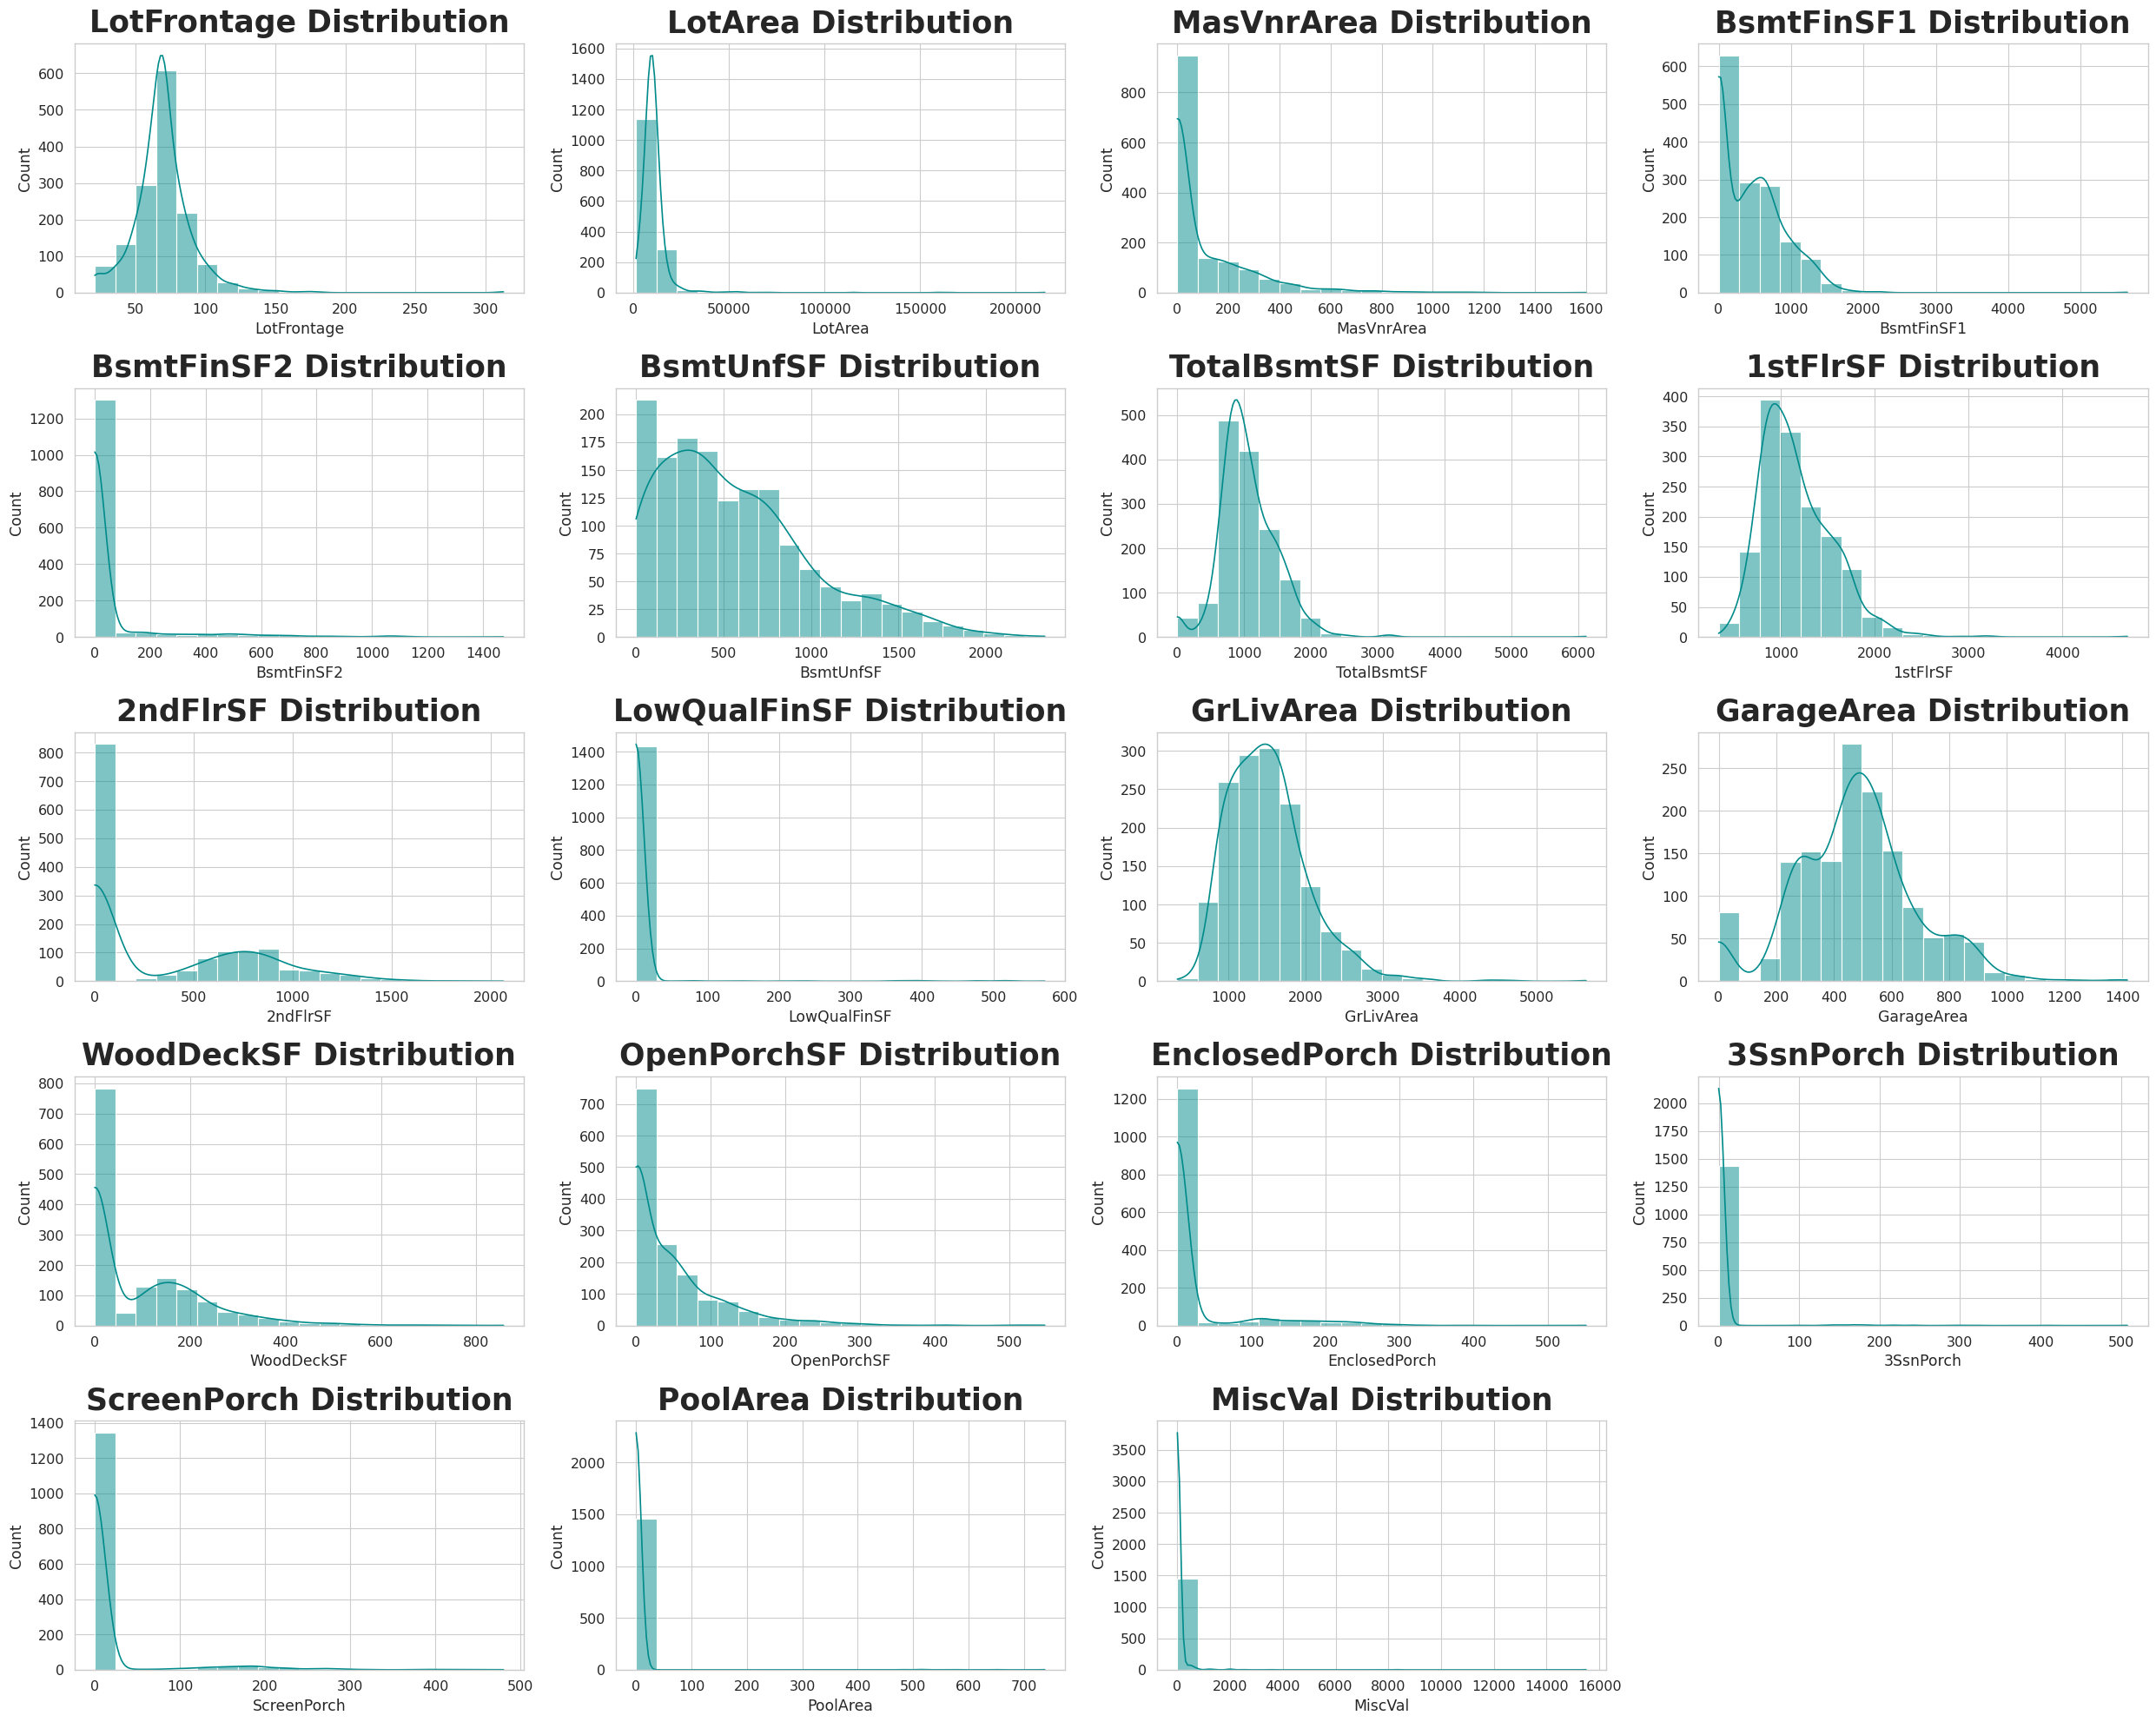

In [23]:
con_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
            'TotalBsmtSF','1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea',
            'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
            'MiscVal']

plt.figure(figsize = (25,20))

for index,column in enumerate(con_cols):
    plt.subplot(5,4,index+1)
    sns.histplot(train[column], bins = 20,kde = True,color = "darkcyan")
    plt.title(f"{column} Distribution",fontweight = "black",size = 25,pad = 10)
    plt.tight_layout()

* Most of continous variables have highly-skewed distribution
* For a non-negligible part of variables is caused by big number of zeros
* For linear regression would be good use some transformation (log, sqrt, exp, boxcox), but I won't use linear regresion, so I will only normalize later.

## **Exploring Categorical Variables** 

In [24]:
sns.color_palette("Set2")
cat_cols = train.select_dtypes(include = ['object']).columns.tolist()

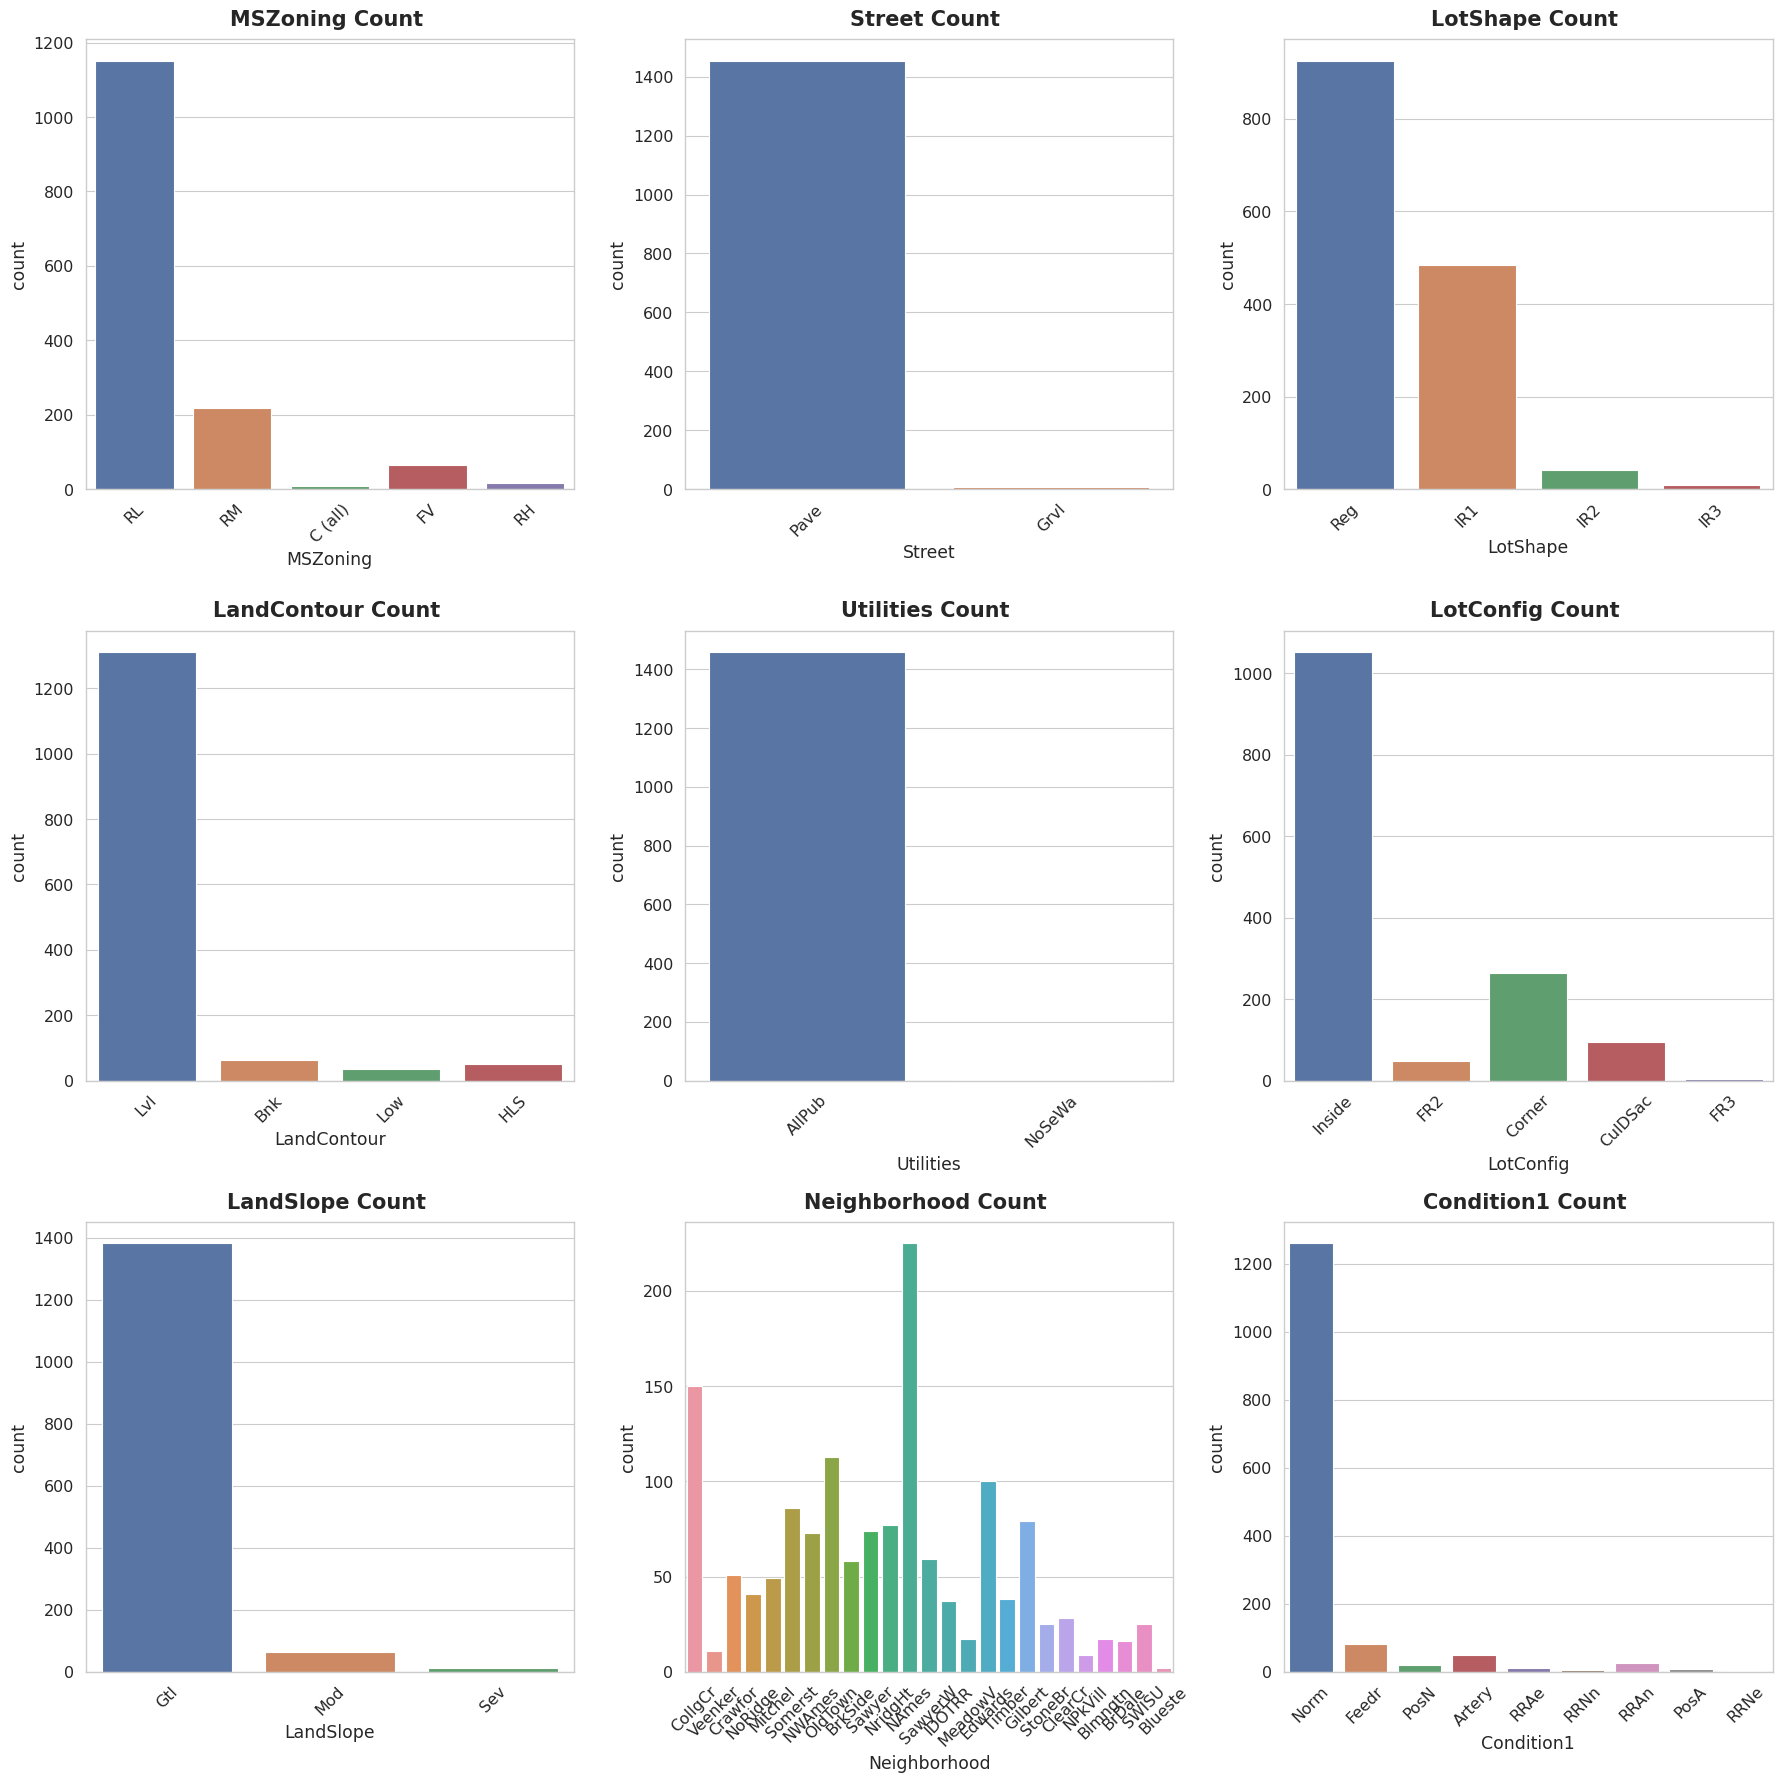

In [25]:
def countplot(cols):
    plt.figure(figsize = (18, 18))
    for index,col in enumerate(cols):
        plt.subplot(3, 3, index+1)
        sns.countplot(x = col, data = train)
        plt.title(f"{col} Count ",fontweight = "black",pad = 10,size = 15)
        plt.xticks(rotation=45)
        plt.tight_layout()

countplot(cat_cols[0:9])

* Street and Utilities variables has very high class imbalance (almost all samples are in 1 class)
* I will drop these variables, so the are not that usefull for predictions
* Neighborhood has high class cardinality which can be fixed by encoding

In [26]:
train.drop(columns=["Utilities","Street"],inplace=True)
test.drop(columns=["Utilities","Street"],inplace=True)

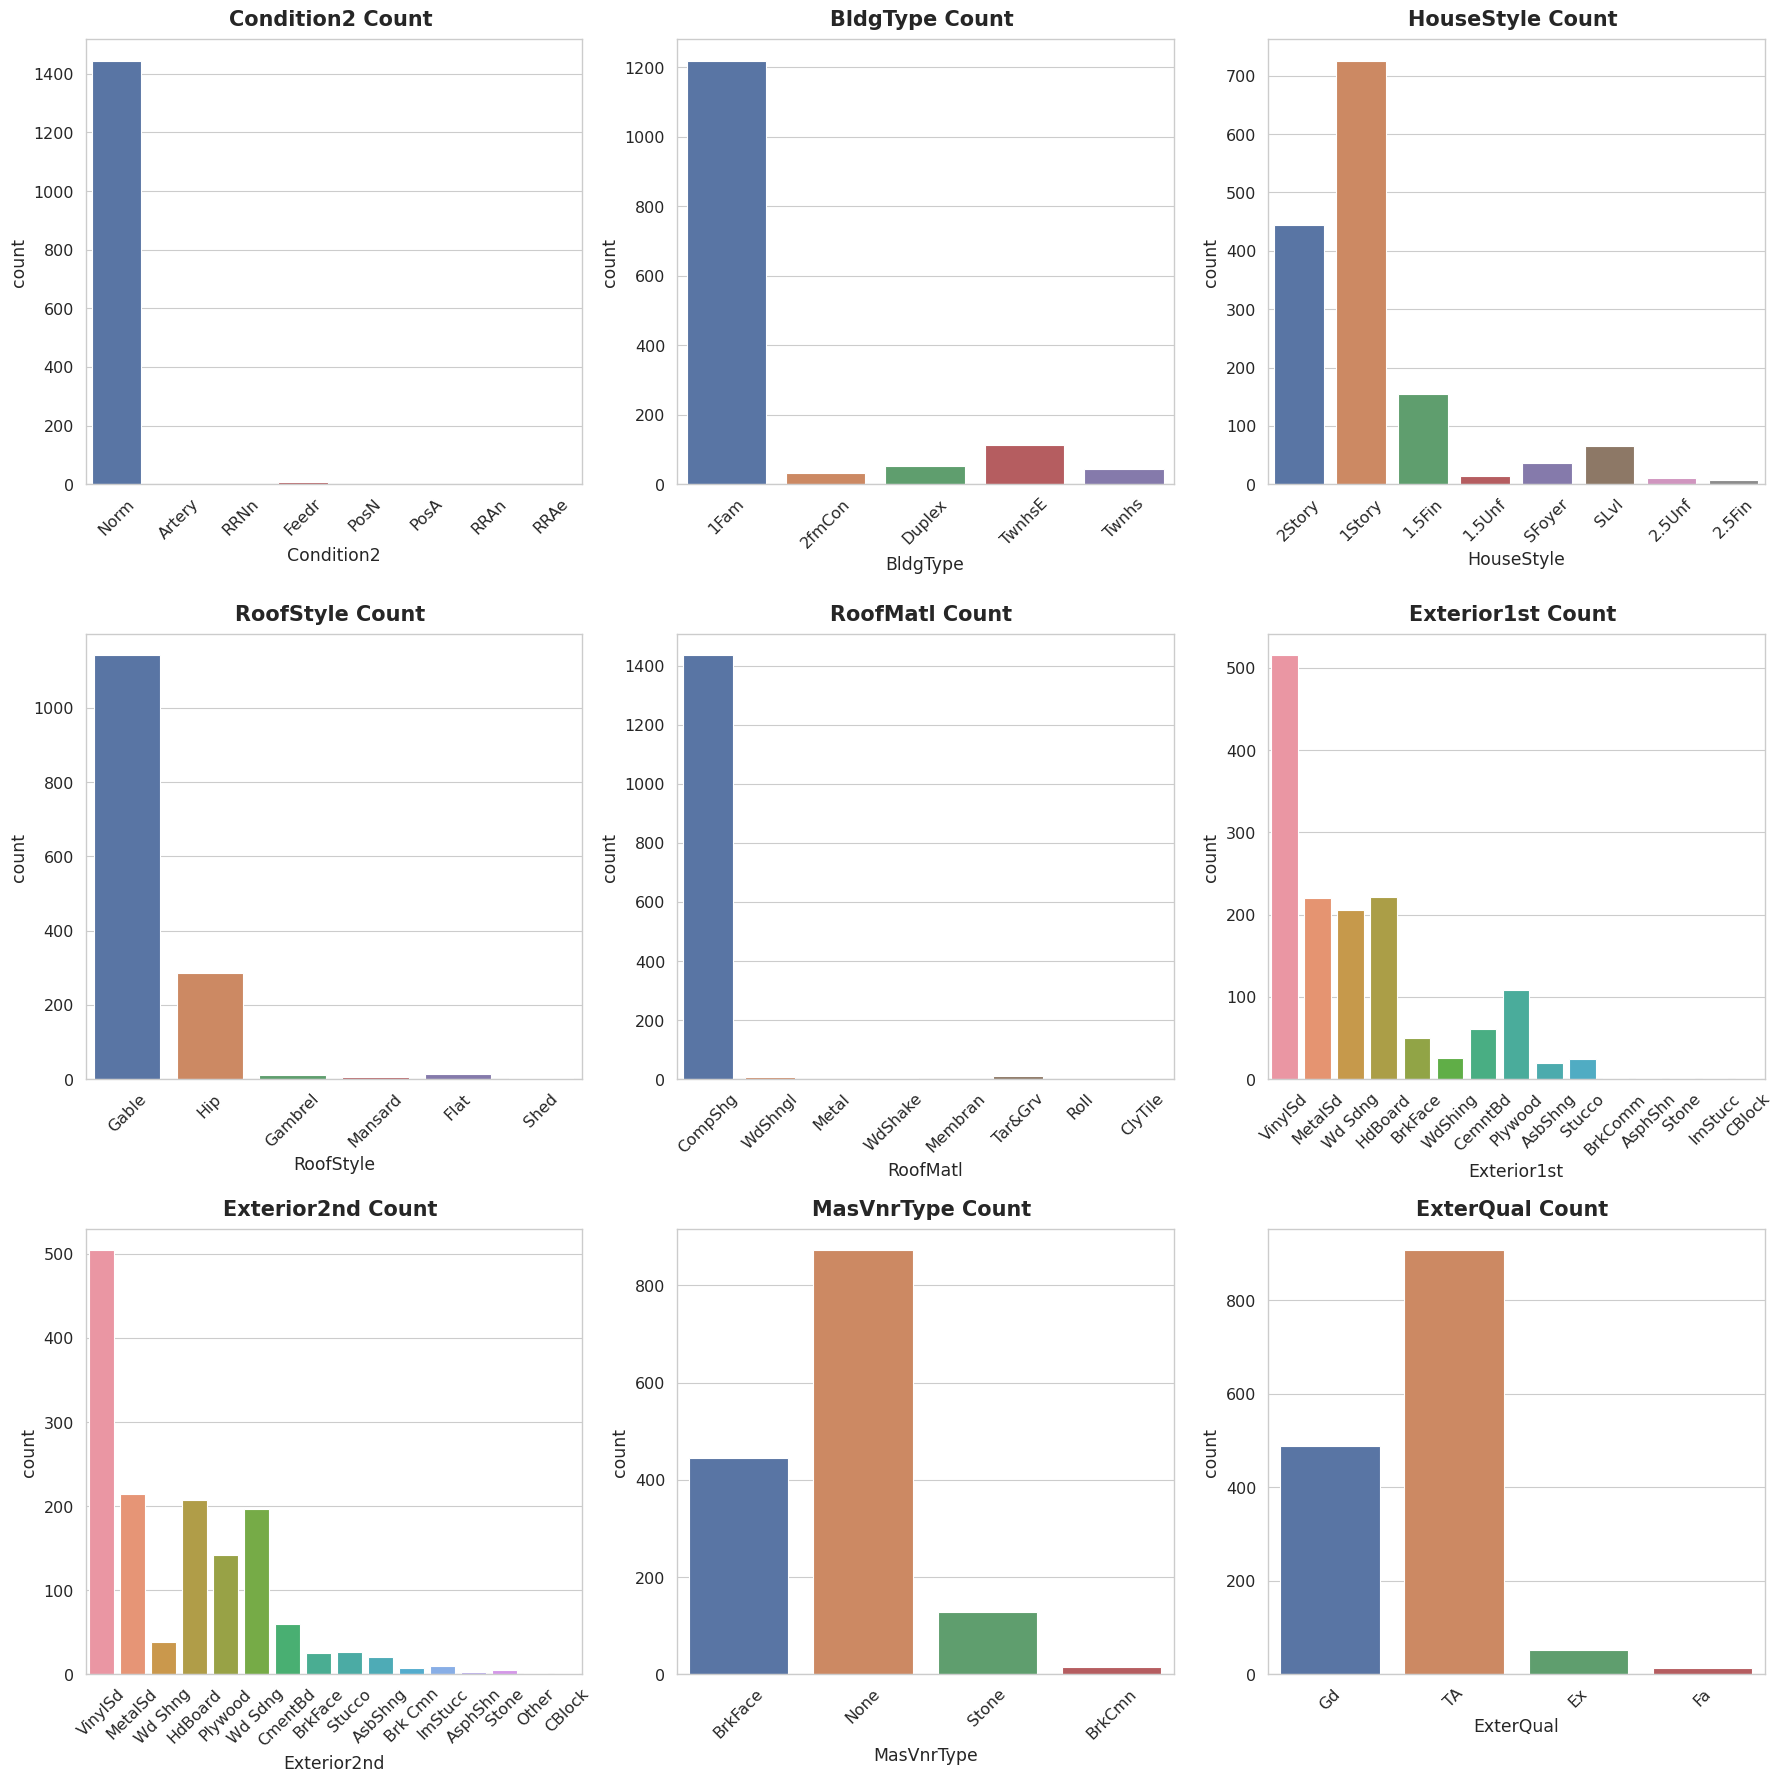

In [27]:
countplot(cat_cols[9:18])

* Condition2 has high class imbalance but can be fixed by feature engineering
* RoofMatl has high class imbalance, so I will drop it
* both Exterior variables has higher cardinality which can be improved by encoding

In [28]:
train.drop(columns=["RoofMatl"],inplace=True)
test.drop(columns=["RoofMatl"],inplace=True)

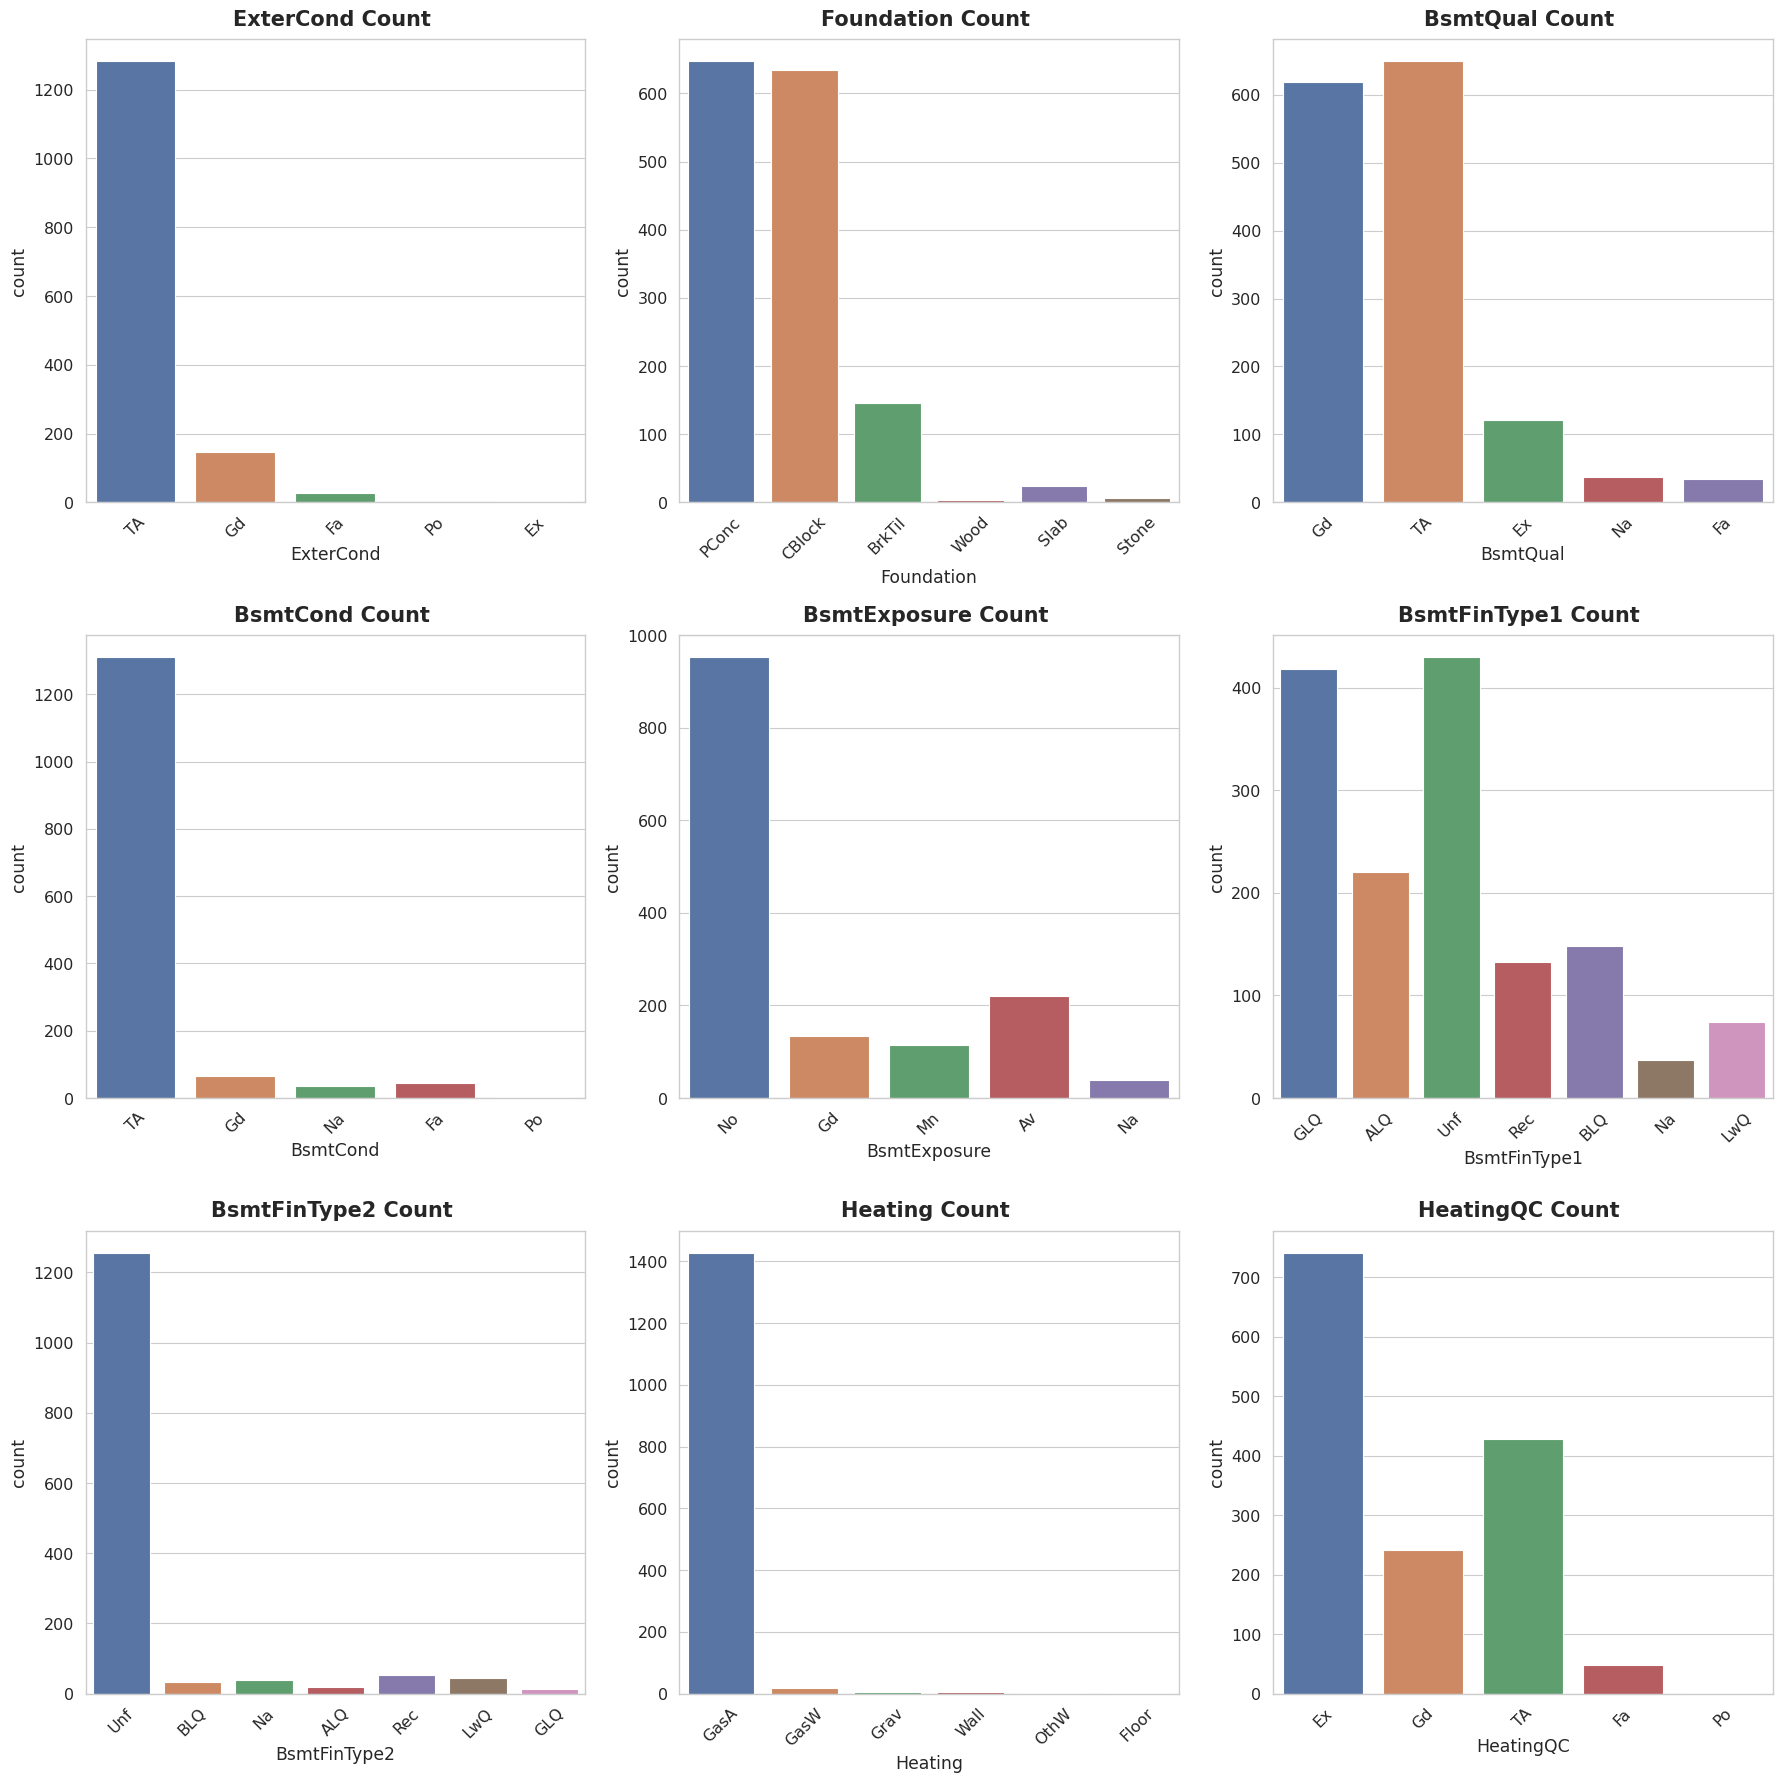

In [29]:
countplot(cat_cols[18:27])

* Heating seems inbalance but could be very important for people when choosing house to buy.

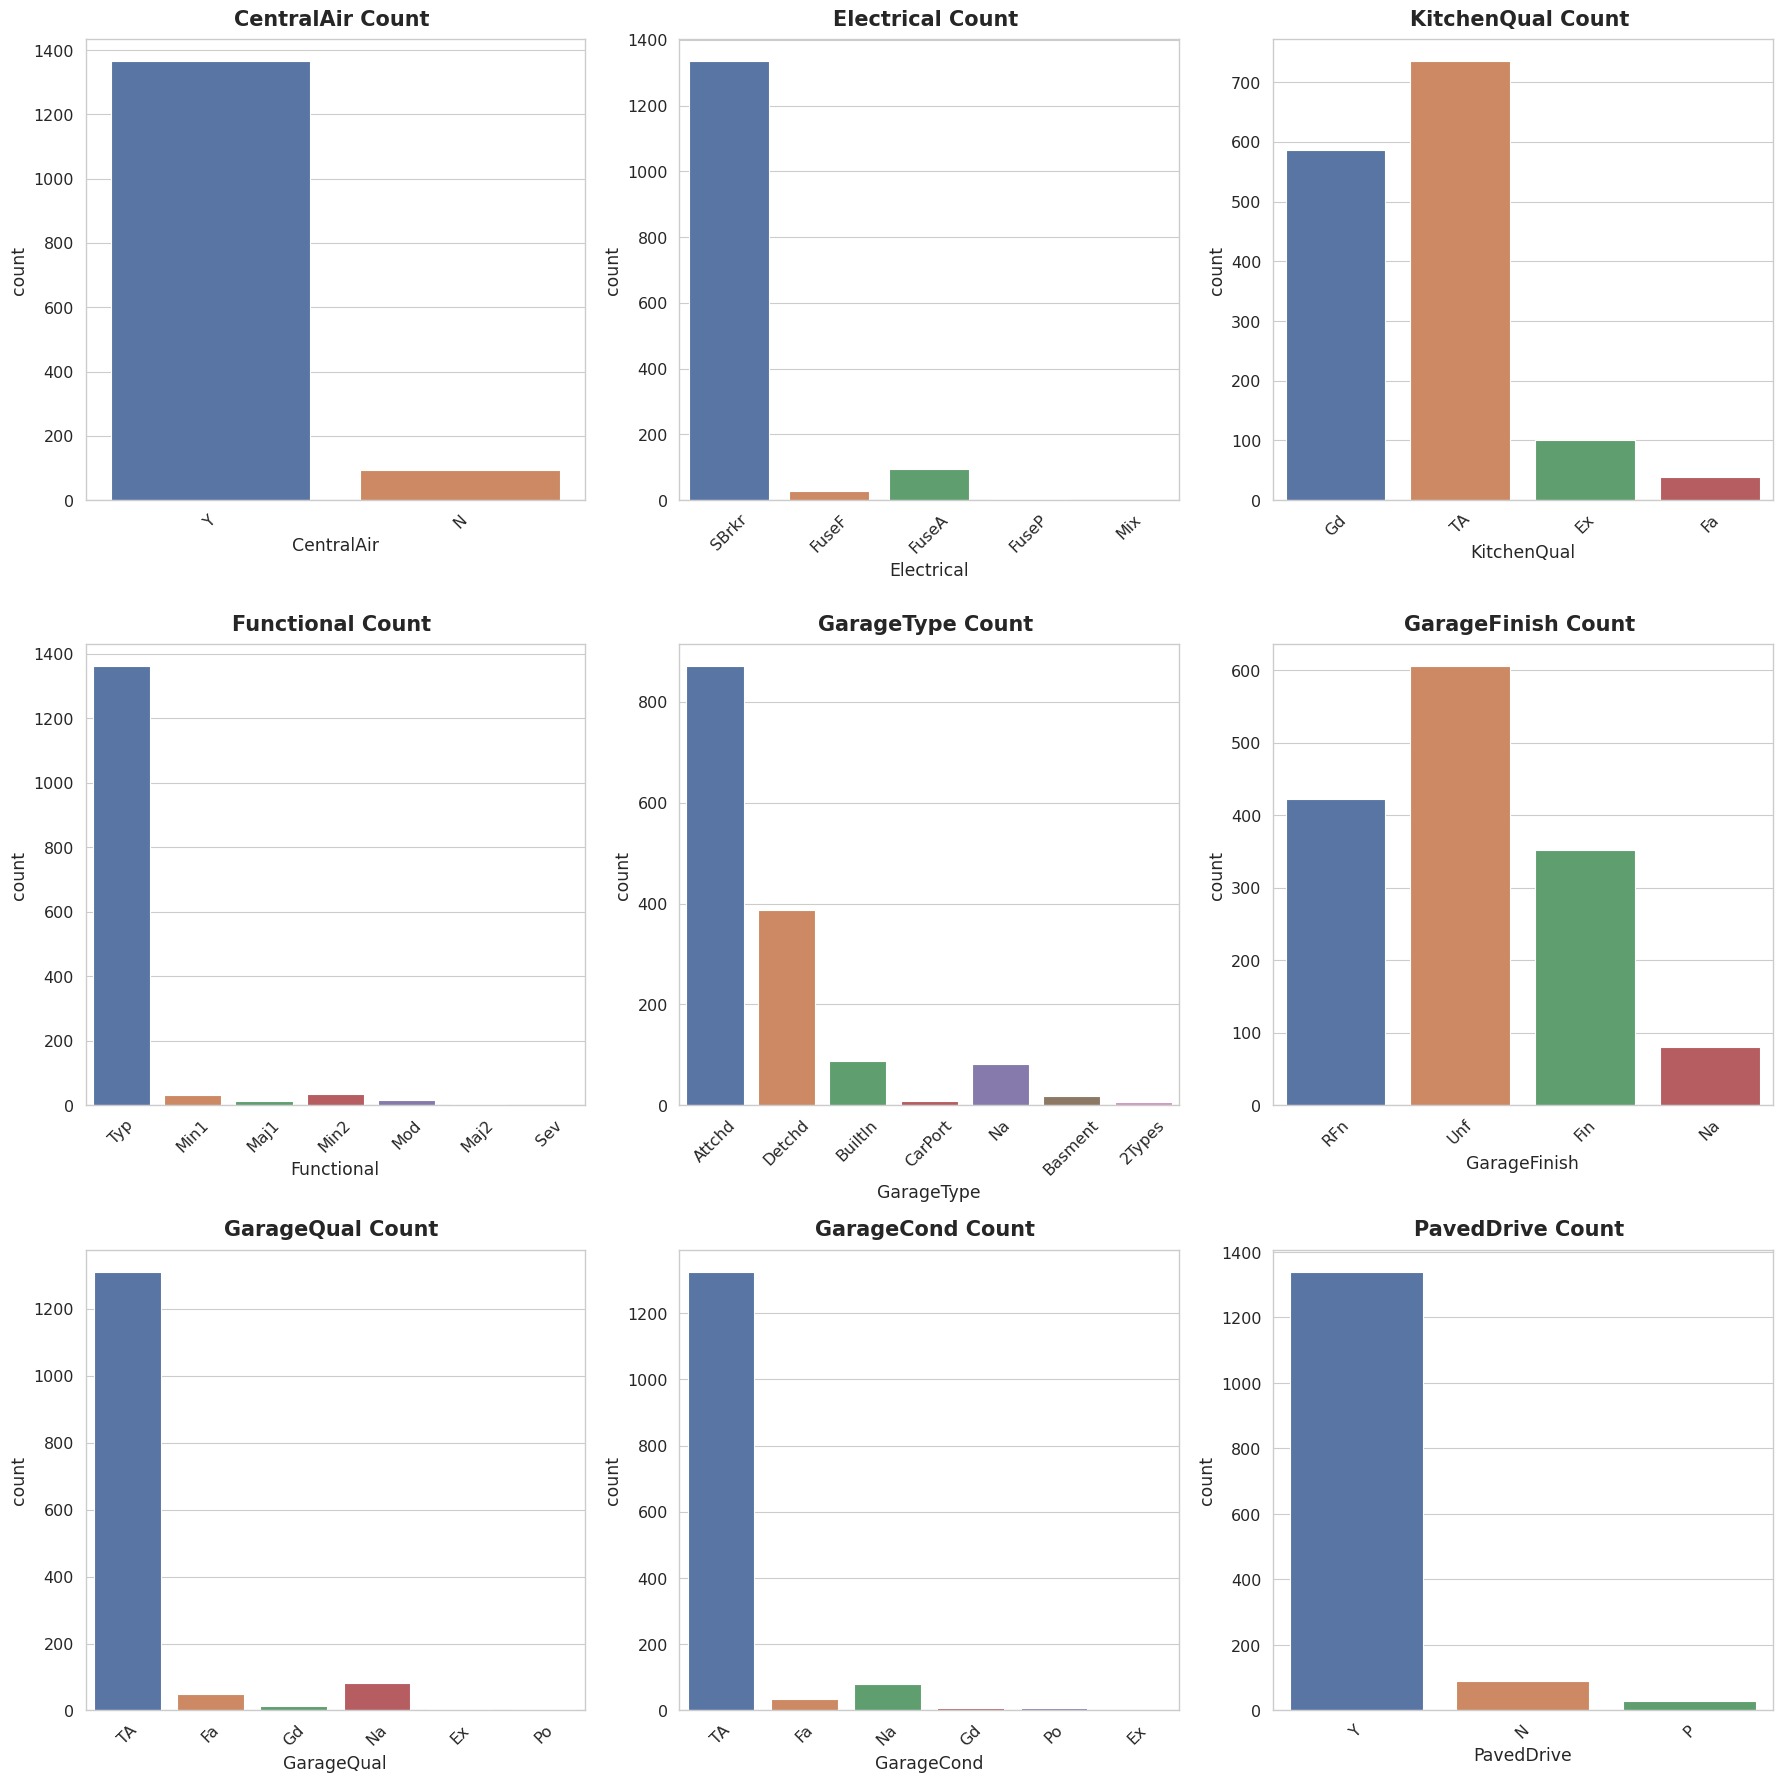

In [30]:
countplot(cat_cols[27:36])

* CentralAir and Functional is the same problem as Heating variable

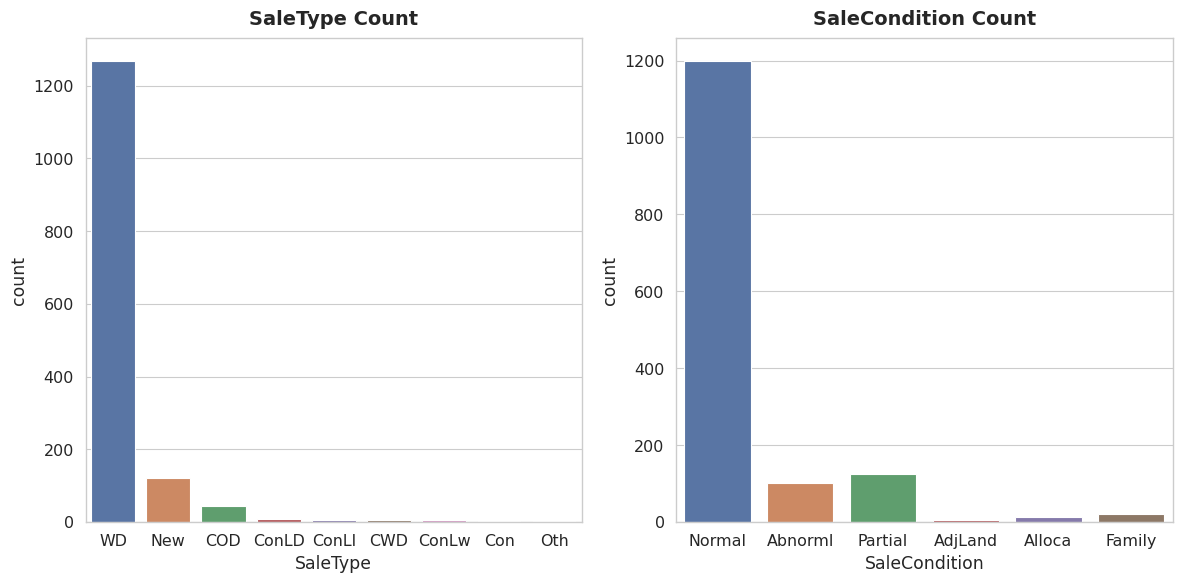

In [31]:
plt.figure(figsize = (12,6))

plt.subplot(1, 2, 1)
sns.countplot(x = train[cat_cols[-2]])
plt.title("SaleType Count",fontweight = "black",pad = 10,size = 14)

plt.subplot(1, 2, 2)
sns.countplot(x = train[cat_cols[-1]])
plt.title("SaleCondition Count",fontweight = "black",pad = 10,size = 14)
plt.tight_layout()
plt.show()

* All other variables seem okay and usefull for predictions

## **Exploring Relationships between Target Variable and Features**

## Discrete Numerical Variables

In [32]:
dis_cols = ["OverallQual", "OverallCond", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath",
            "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "MoSold"]

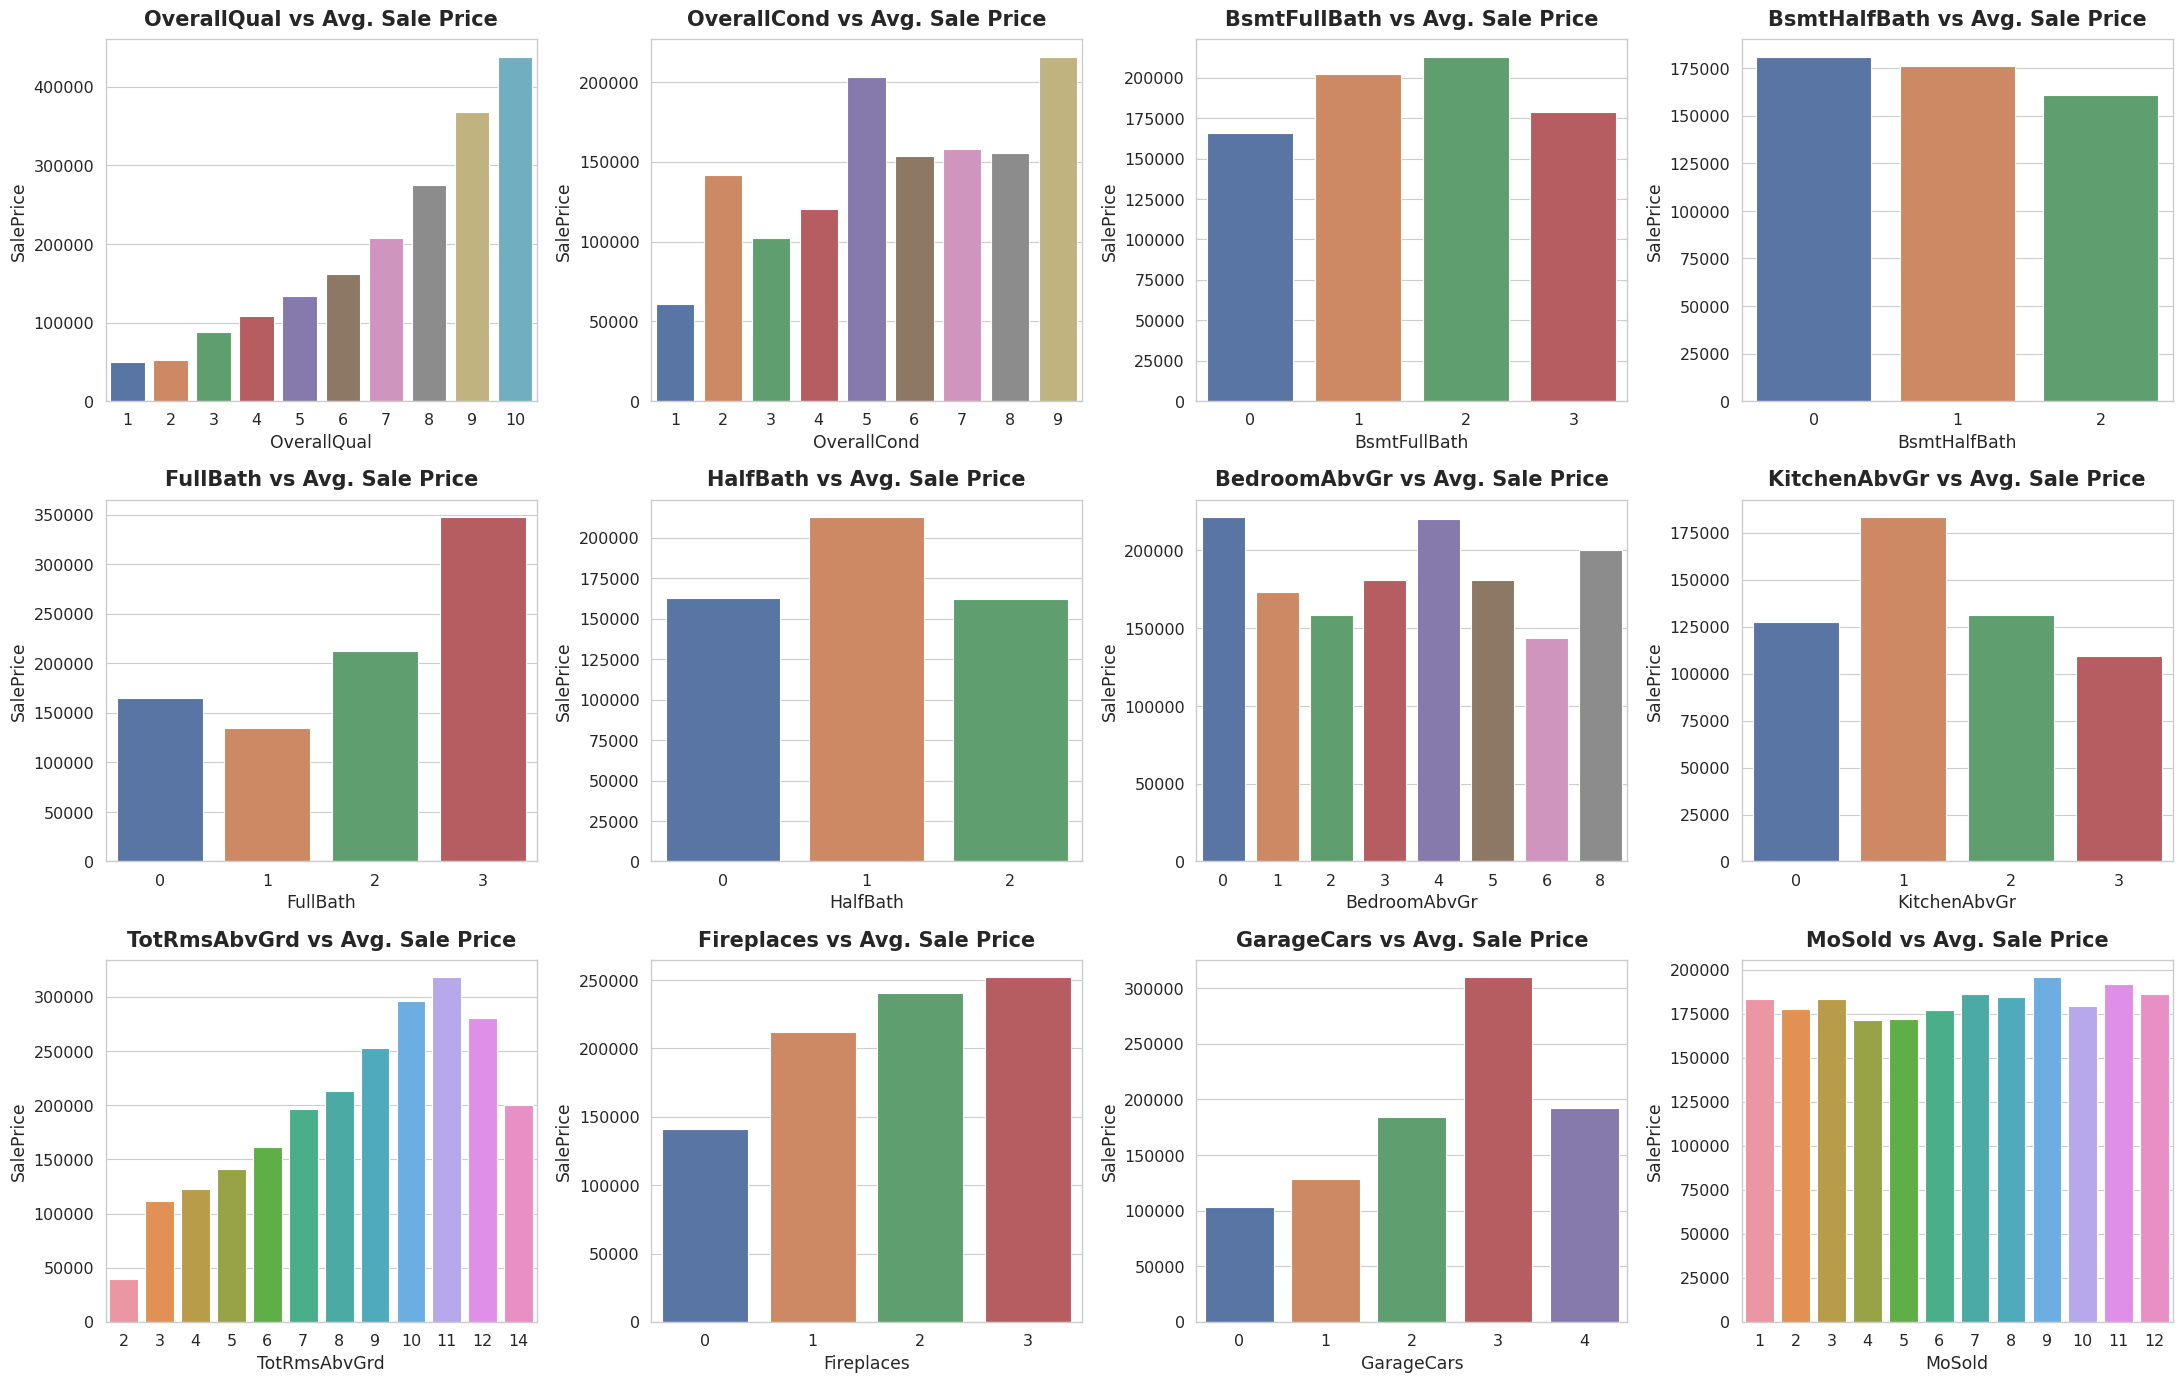

In [33]:
plt.figure(figsize=(22,14))
for index, col in enumerate(dis_cols):
    plt.subplot(3, 4, index+1)
    sns.barplot(x = col, y = 'SalePrice', data = train, estimator = 'mean', errorbar = None)
    plt.title(f"{col} vs Avg. Sale Price", fontweight = "black", size = 15,pad = 10)
    plt.tight_layout()

* OverallQual, OverallCond, FullBath, GarageCars variables have strong positive correlation with target
* BsmtHalfBath has negative correlation with target
* Other variables also has relationship with target but is not linear

## Continous Numerical Variables

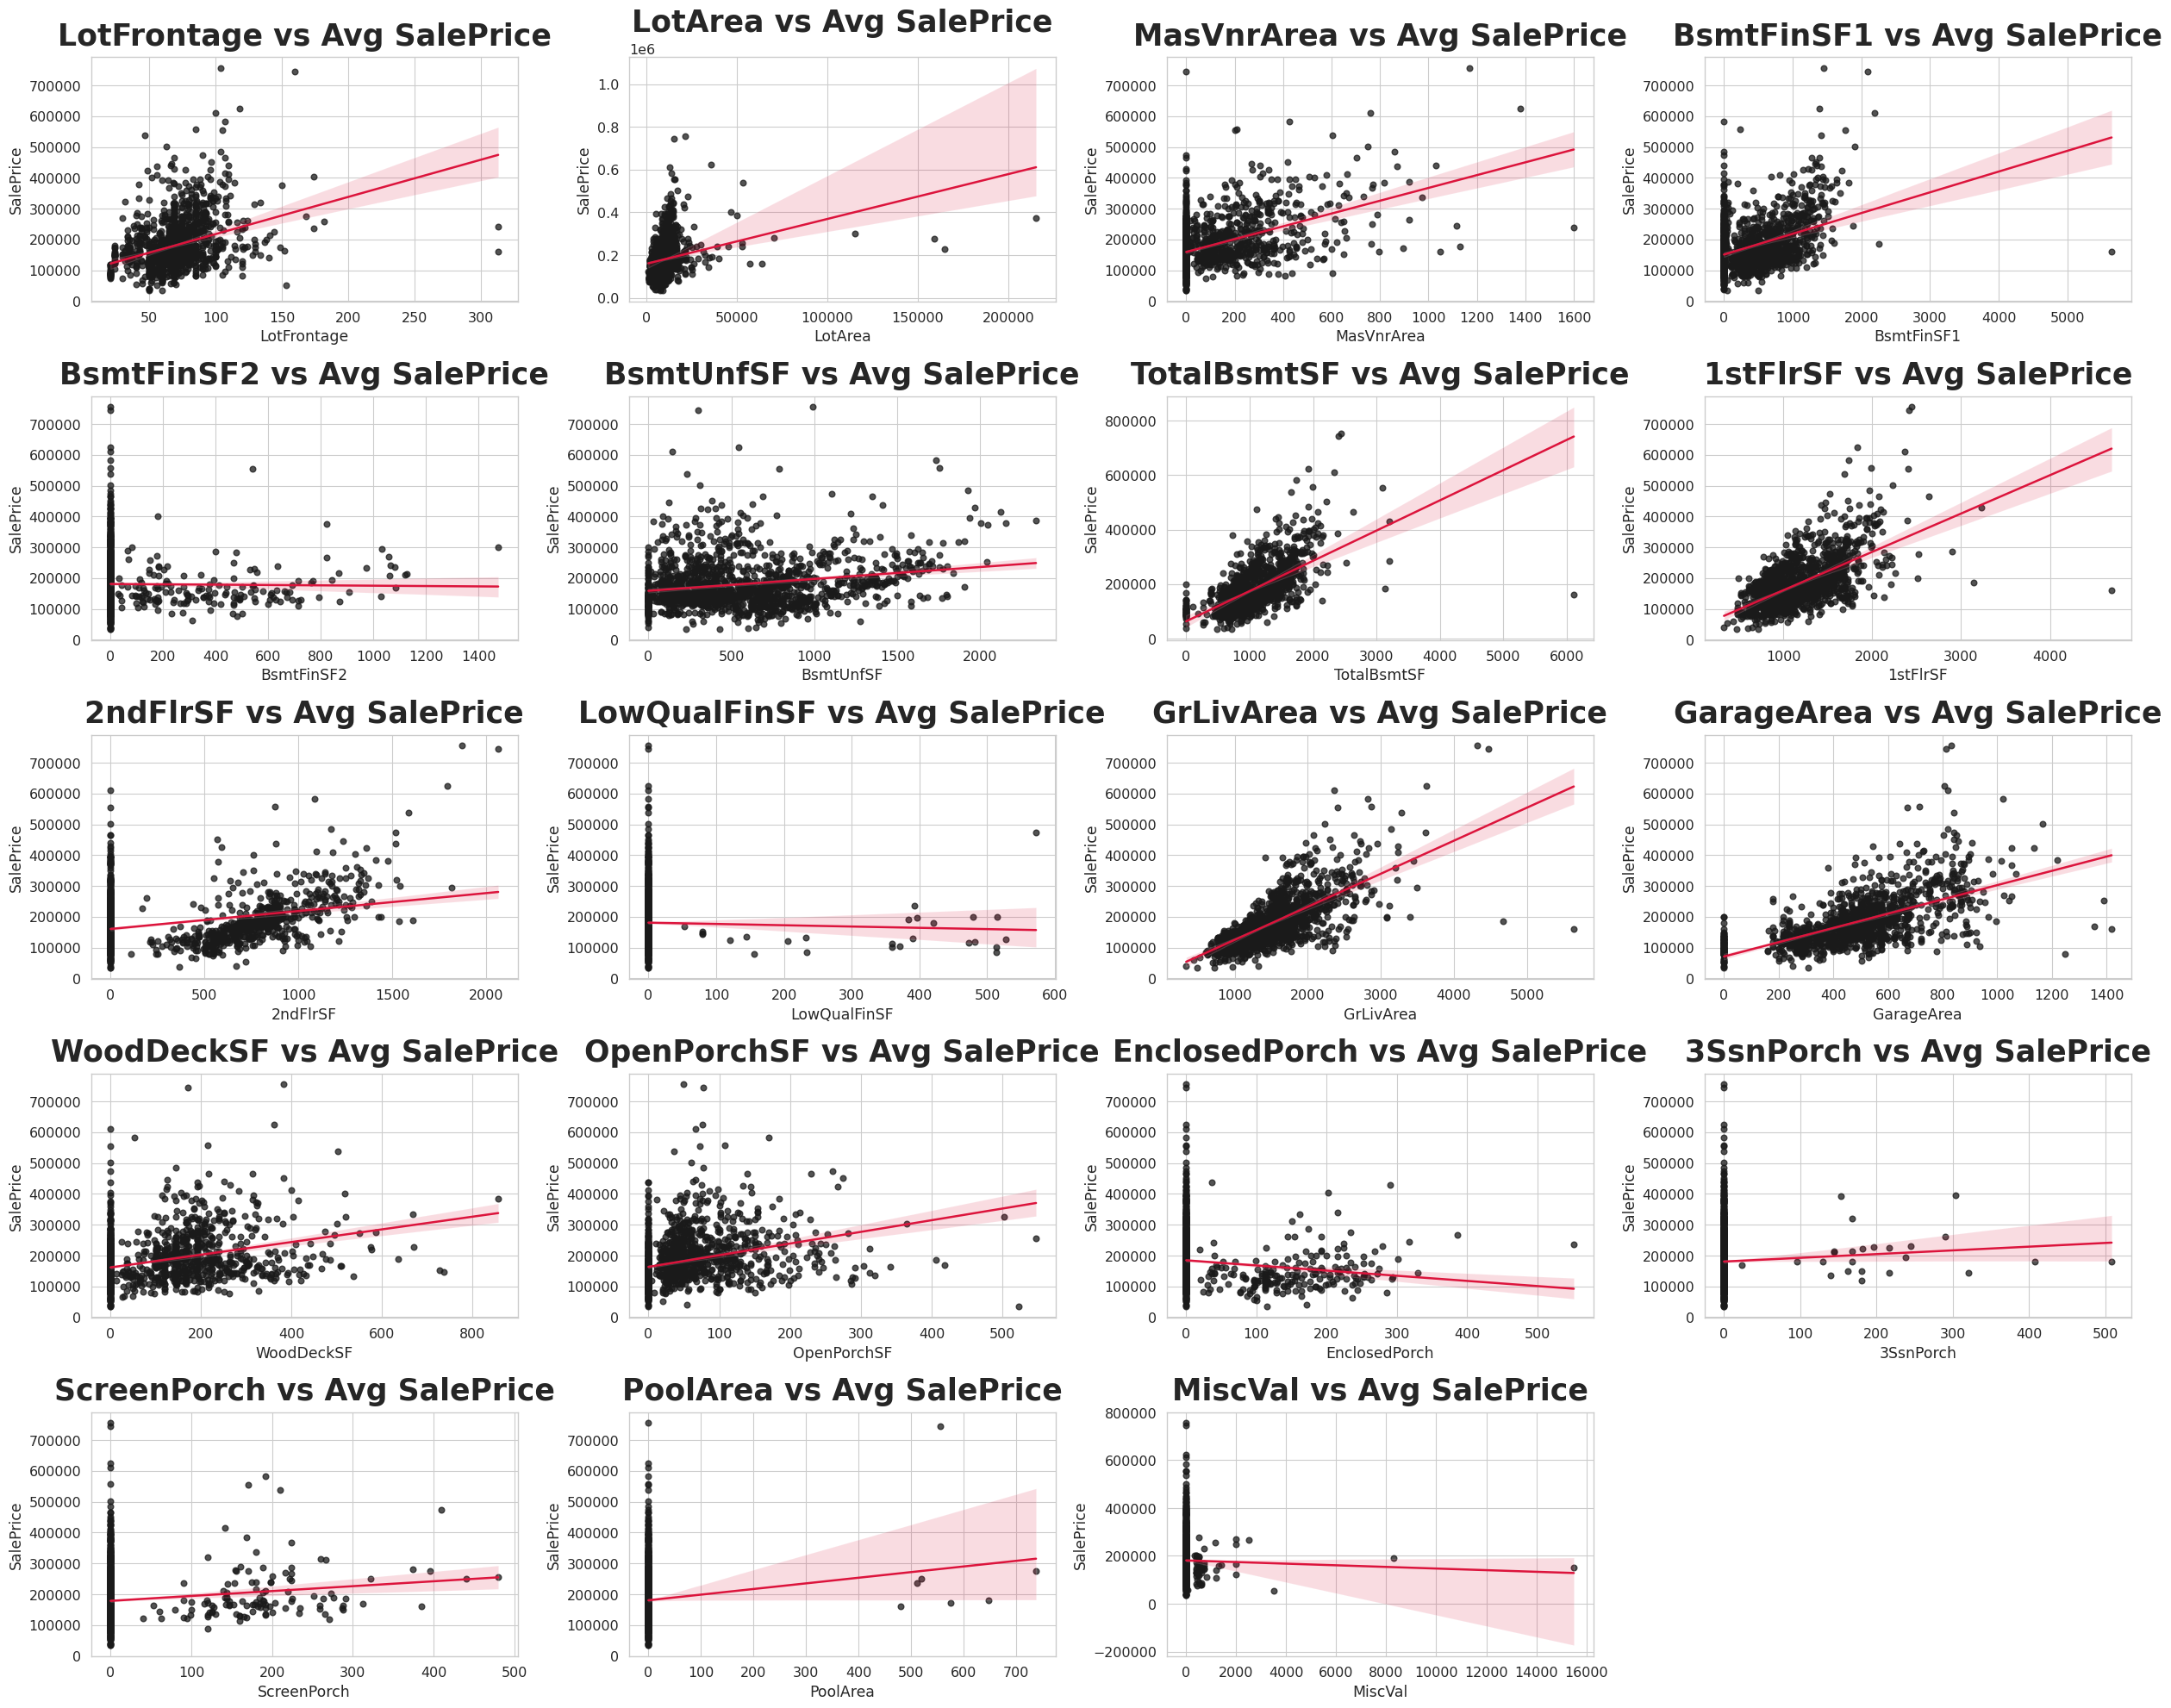

In [34]:
plt.figure(figsize = (25,20))

for index,col in enumerate(con_cols):
    plt.subplot(5,4,index+1)
    sns.regplot(x = col, y = 'SalePrice', data = train,
                scatter_kws = {'color' : 'k', 'alpha' : 0.75},
                line_kws = {'color' : 'crimson'})
    plt.title(f"{col} vs Avg SalePrice",fontweight = "black",size = 25,pad = 10)
    plt.tight_layout()

* LowQualFinSF, PoolArea, and MiscVal features have low correlation with target. Also majority of smaples are 0, so I will drop these columns
* BsmtFinSF2 is also low correlated with target but could be used in feature engineering
* Other variables are usefull

In [35]:
train.drop(columns = ['PoolArea', 'MiscVal', 'LowQualFinSF'], inplace = True)
test.drop(columns = ['PoolArea', 'MiscVal', 'LowQualFinSF'], inplace = True)

## Categorical Variables

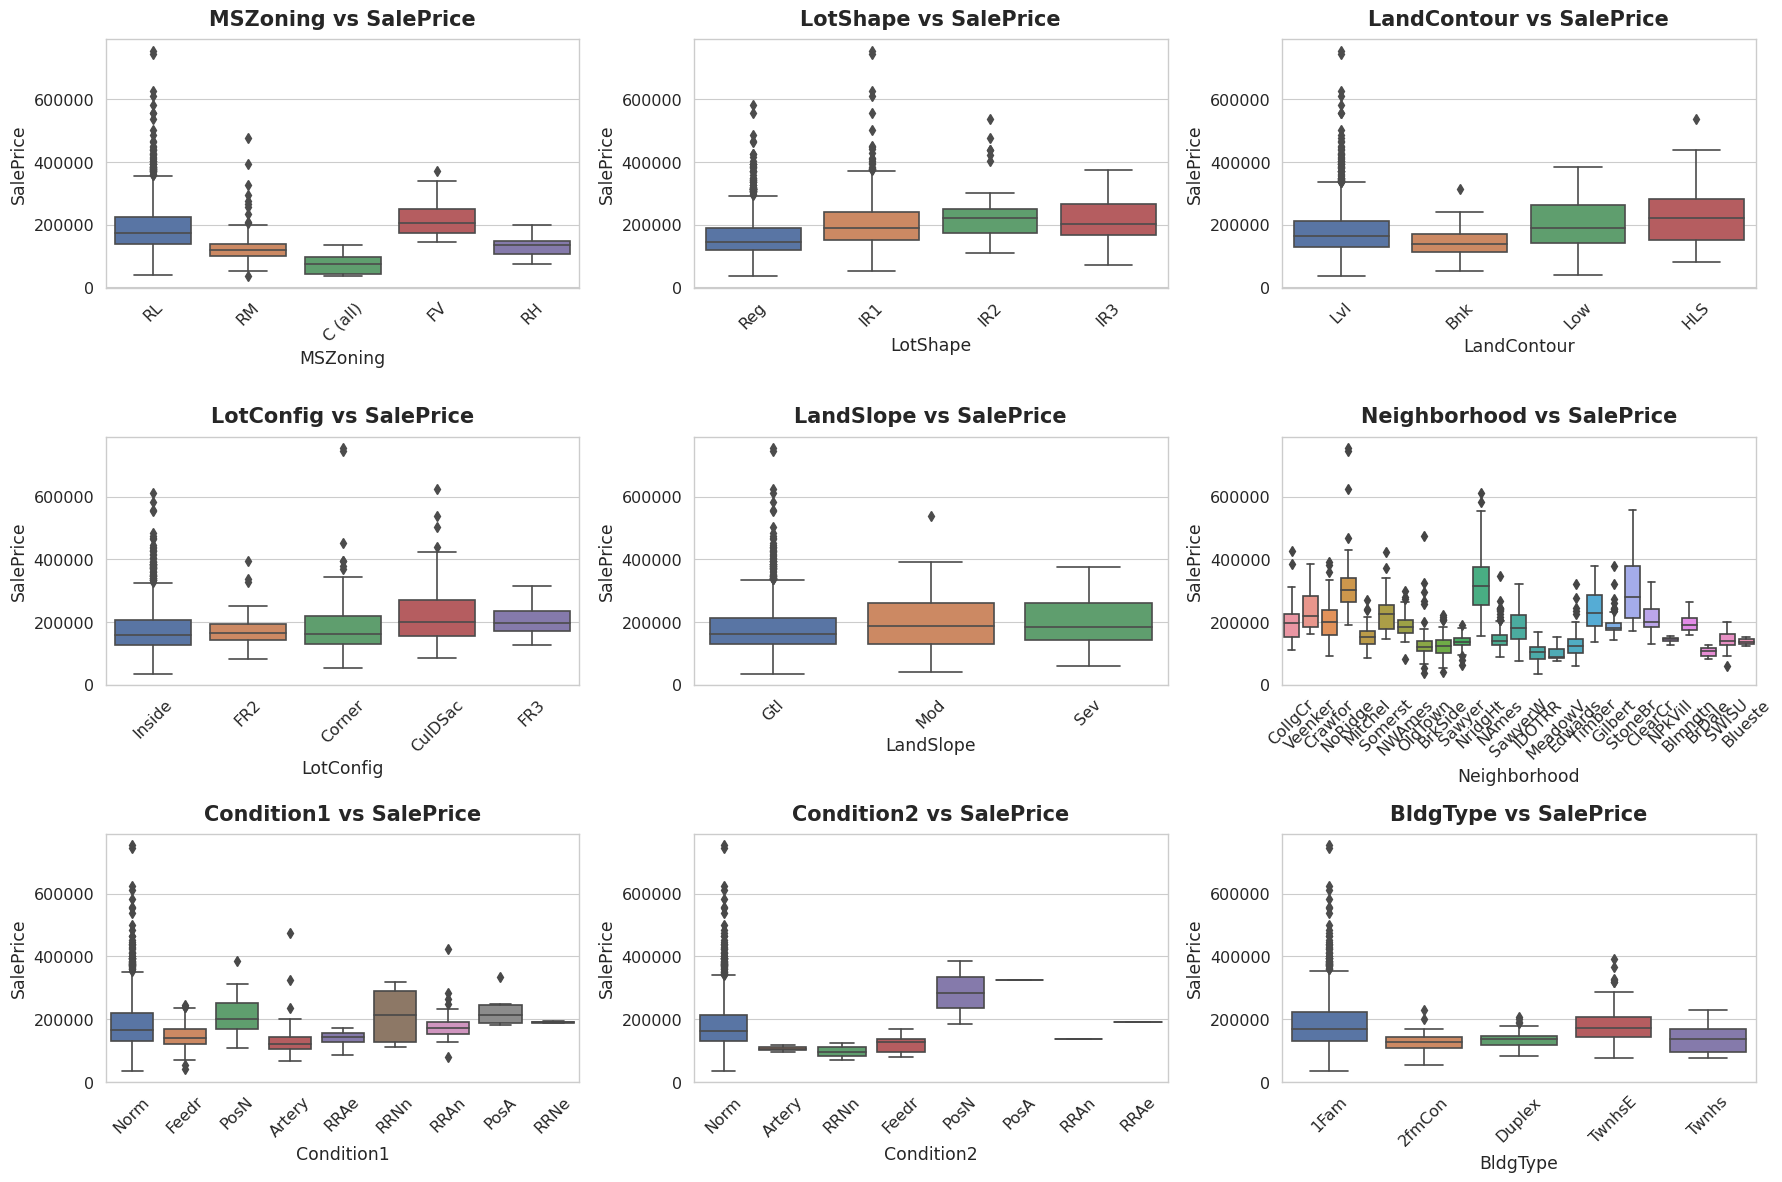

In [36]:
cat_cols = train.select_dtypes(include = 'object').columns.tolist()
def boxplot(cols):
    plt.figure(figsize = (18,12))
    for index,col in enumerate(cols):
        plt.subplot(3, 3, index+1)
        sns.boxplot(x = col, y = "SalePrice", data = train)
        plt.title(f"{col} vs SalePrice",fontweight = "black",pad = 10,size = 15)
        plt.xticks(rotation=45)
        plt.tight_layout()
        
boxplot(cat_cols[0:9])

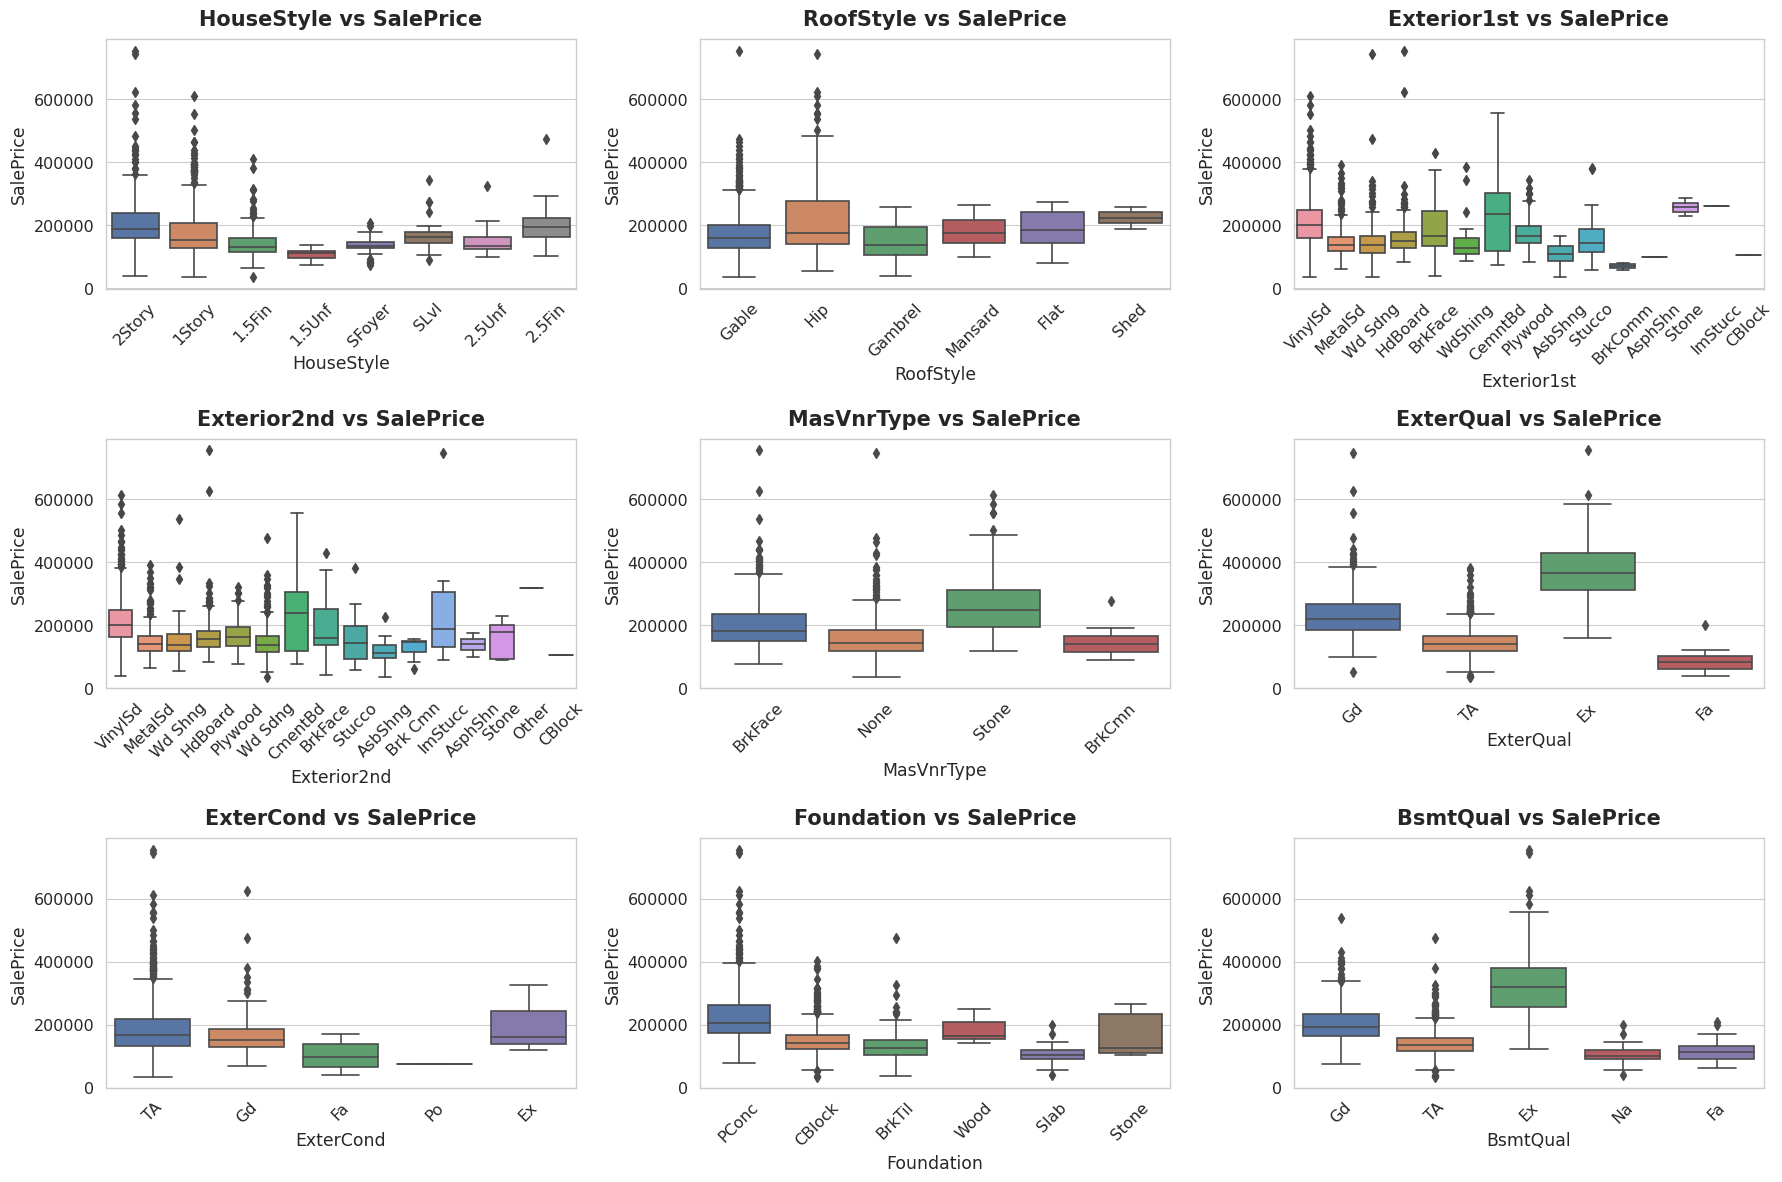

In [37]:
boxplot(cat_cols[9:18])

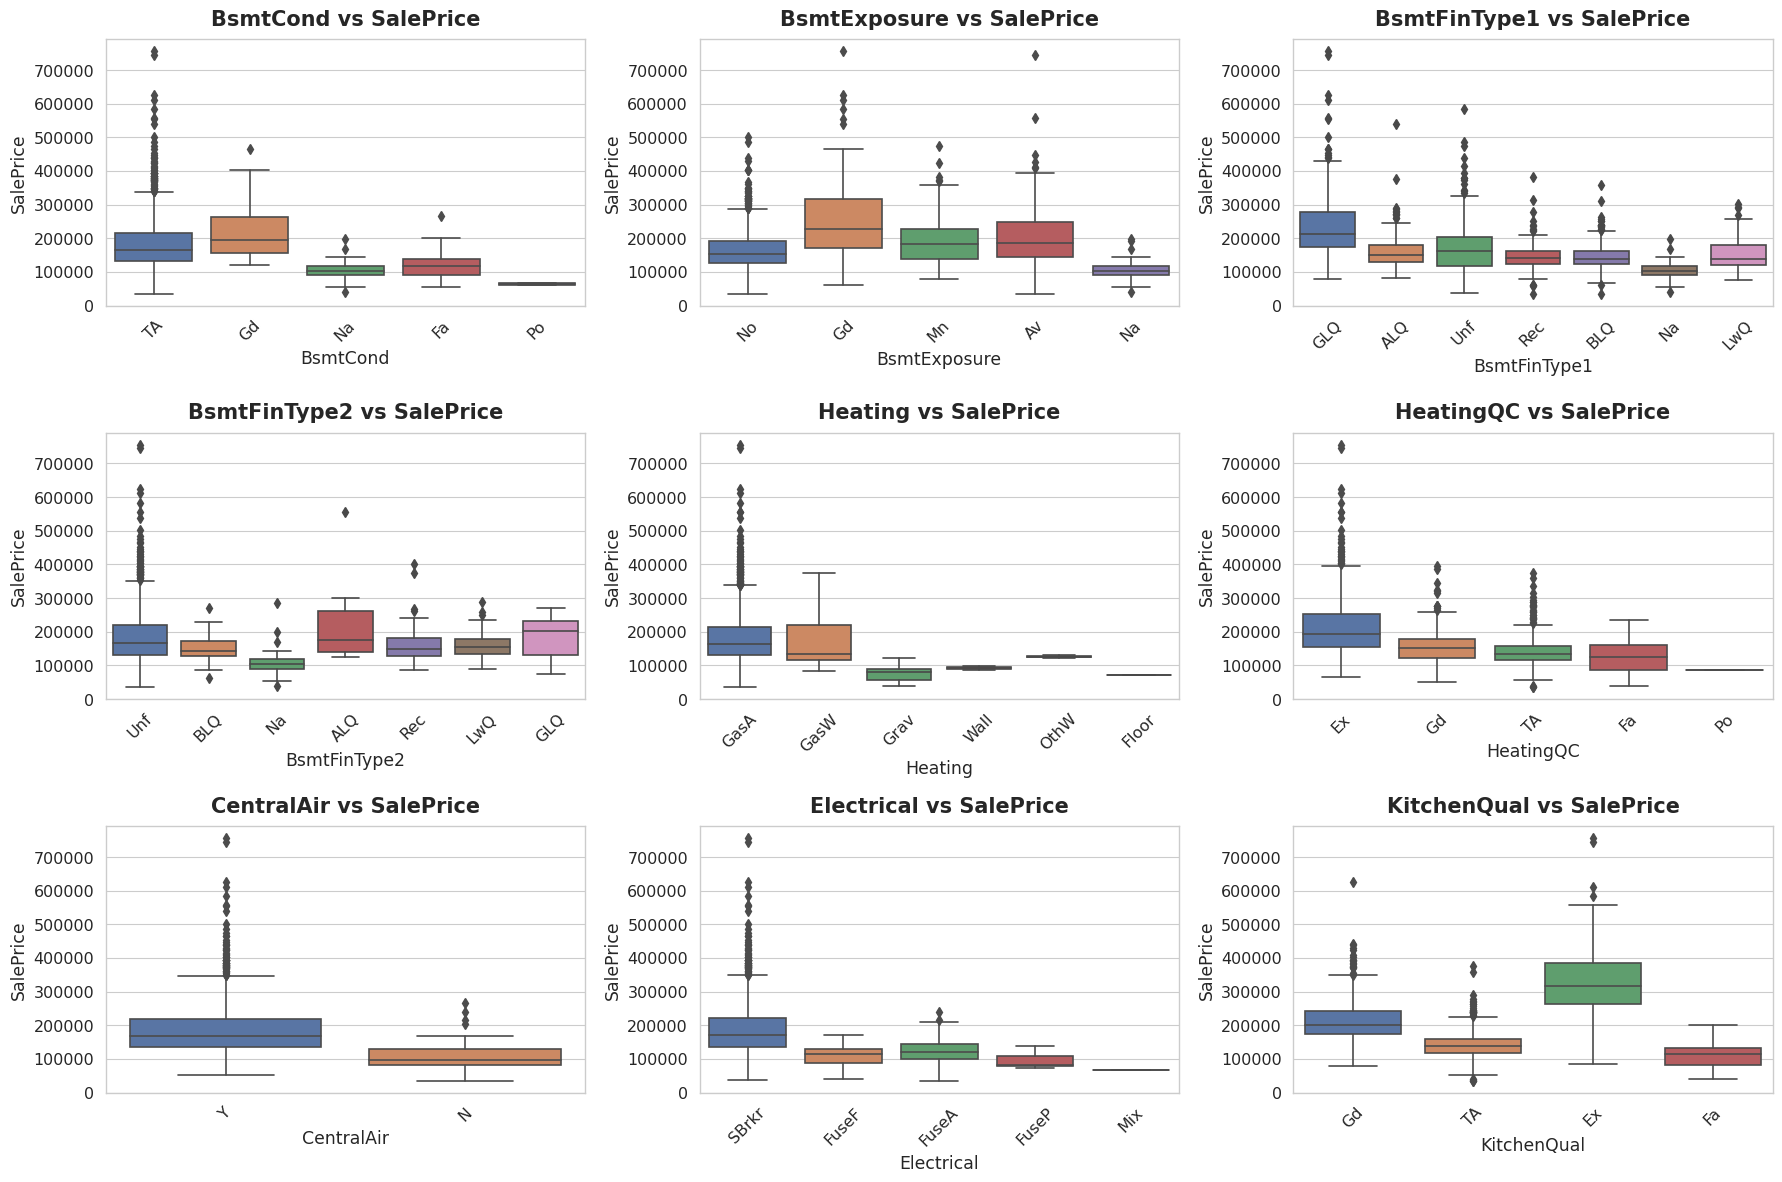

In [38]:
boxplot(cat_cols[18:27])

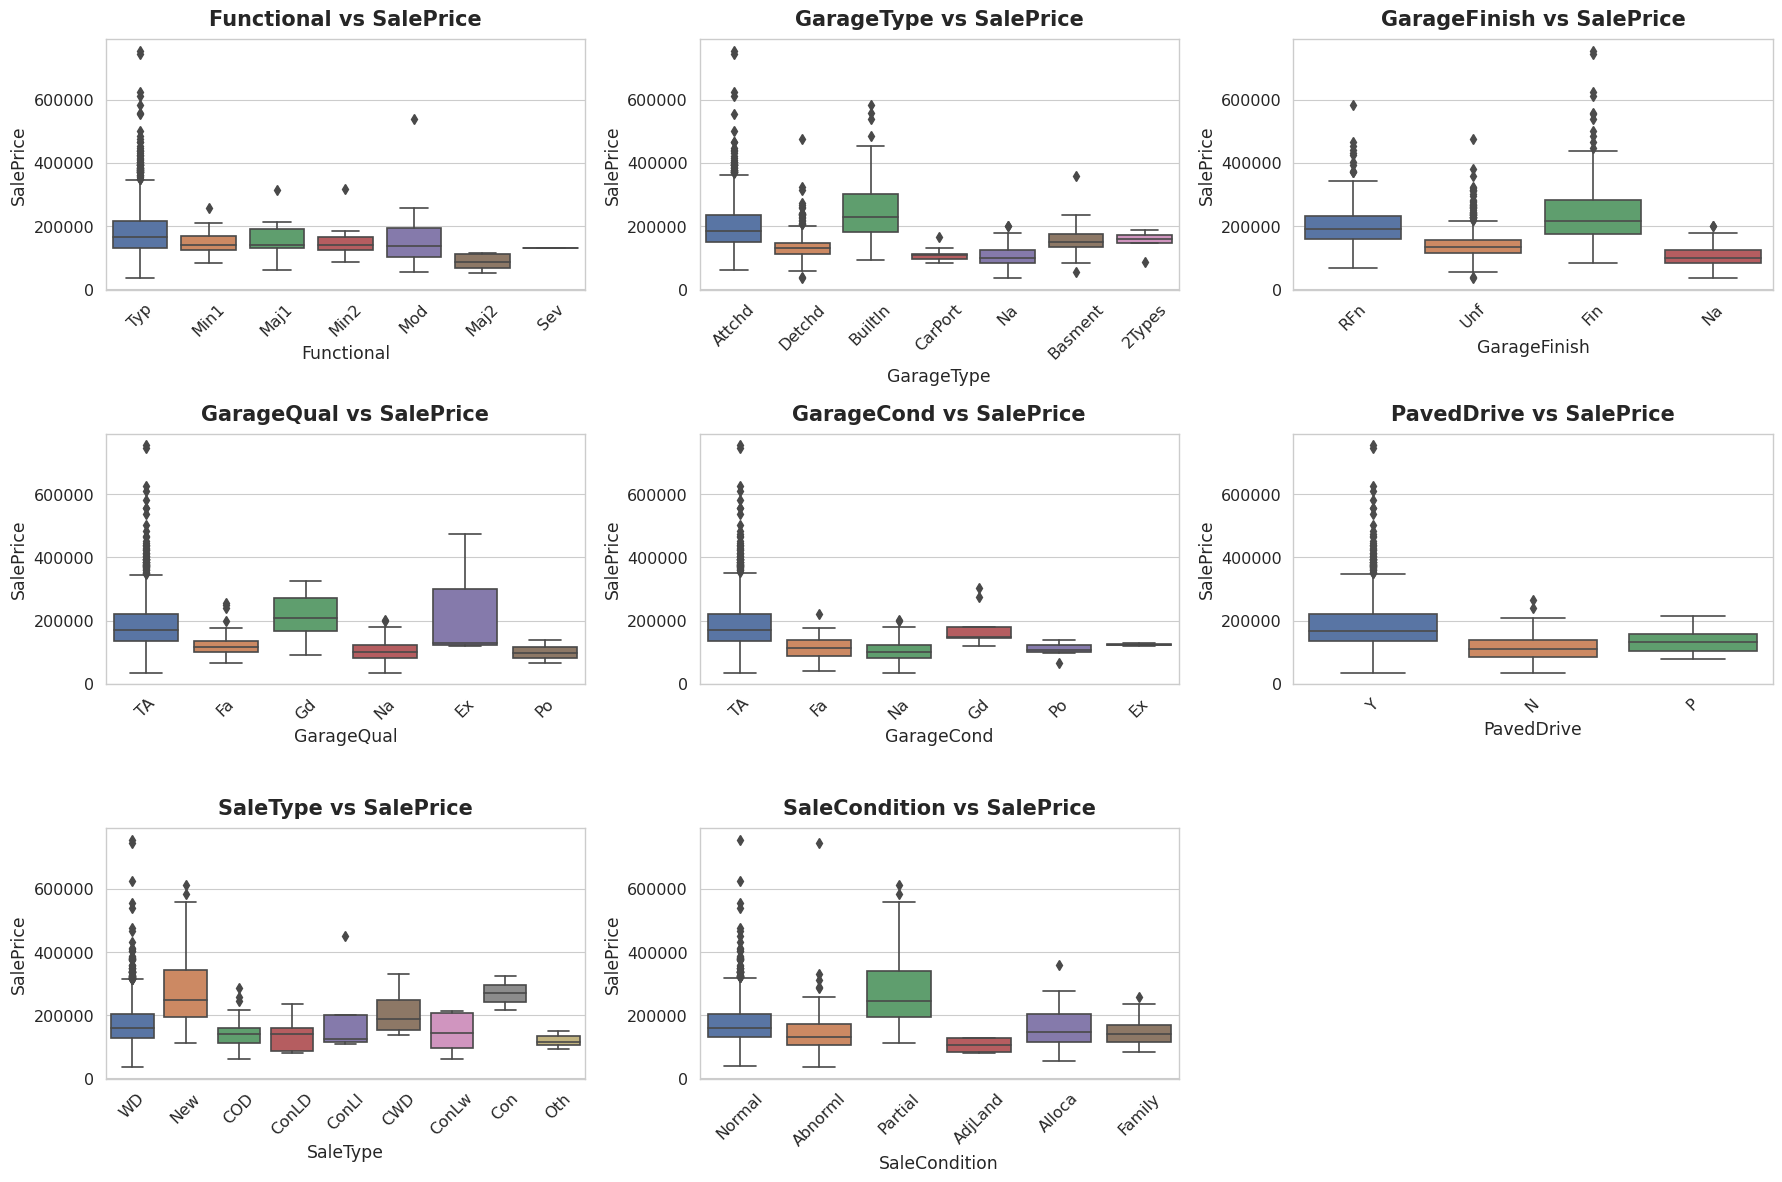

In [39]:
boxplot(cat_cols[27:])

* All categorical variables look usefull for predicting target variable.

# **Feature Engineering**

## **Date Columns**

* There is still 1 type of columns I didn't analyze. Dates columns - YearBuilt, YearRemodAdd, YrSold and GarageYrBlt
* I will combine them to get new features
* First one is boolean that tells us, if the house was remodelled
* Second one shows age at the selling point
* Third one shows if the house has a garage

In [40]:
train['Remodelled'] = (train['YearBuilt'] != train['YearRemodAdd']).astype(int)
test['Remodelled'] = (test['YearBuilt'] != test['YearRemodAdd']).astype(int)

train['AgeSold'] = train['YrSold'] - train['YearBuilt'].astype(int)
test['AgeSold'] = test['YrSold'] - test['YearBuilt'].astype(int)

train['Garage'] = (train['GarageYrBlt'] != 0).astype(int)
test['Garage'] = (test['GarageYrBlt'] != 0).astype(int)

In [41]:
train.drop(columns = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'], inplace = True)
test.drop(columns = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'], inplace = True)

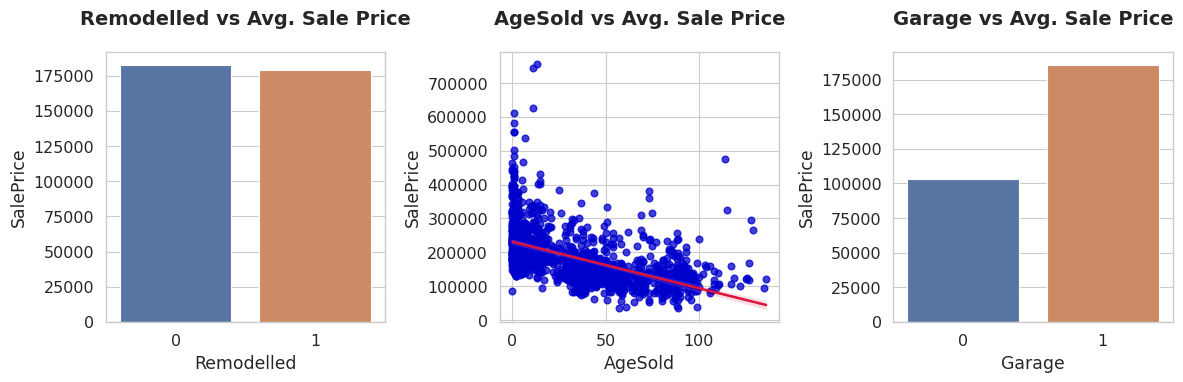

In [42]:
plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
sns.barplot(x = 'Remodelled', y = 'SalePrice', data = train, estimator = 'mean', errorbar = None)
plt.title("Remodelled vs Avg. Sale Price", fontweight = "black", size = 14,pad = 20)

plt.subplot(1, 3, 2)
sns.regplot(x = 'AgeSold', y = 'SalePrice', data = train,
                scatter_kws = {'color' : 'mediumblue', 'alpha' : 0.75},
                line_kws = {'color' : 'crimson'})
plt.title("AgeSold vs Avg. Sale Price", fontweight = "black", size = 14,pad = 20)

plt.subplot(1, 3, 3)
sns.barplot(x = 'Garage', y = 'SalePrice', data = train, estimator = 'mean', errorbar = None)
plt.title("Garage vs Avg. Sale Price", fontweight = "black", size = 14,pad = 20)
plt.tight_layout()

* There is almost no difference in SalePrice between renovated and non renovated houses
* AgeSold variable shows high negative correlation with SalePrice
* Houses with garages has more than 1.5 higher value than houses without garage

## **Condition Columns**

* There are 2 Condition columns in dataset. Value Norm is most samples so should be better to have it in just on column.
* Also combinations of conditions creates more categories which can better interpret target.
* Barplot of ProximityStatus and avg SalePrice relationship bellow shows that there is slight difference between categories. 

In [43]:
def condition(df):
    df["Condition2"] = df["Condition2"].replace({"Norm":""})
    combined_condition = []
    for val1,val2 in zip(df["Condition1"],df["Condition2"]):
        if val2 == "":
            combined_condition.append(val1)
        elif val1==val2:
            combined_condition.append(val1)
        else:
            combined_condition.append(val1+val2)
            
    df["Combined_Condition"] = combined_condition
    df["ProximityStatus"] = (df["Combined_Condition"] == "Norm").astype(int)
    
condition(train)
condition(test)

In [44]:
train.drop(columns=['Condition1', 'Condition2', 'Combined_Condition'],inplace=True)
test.drop(columns=['Condition1', 'Condition2', 'Combined_Condition'],inplace=True)

Text(0.5, 1.0, 'ProximityStatus vs Avg. Sale Price')

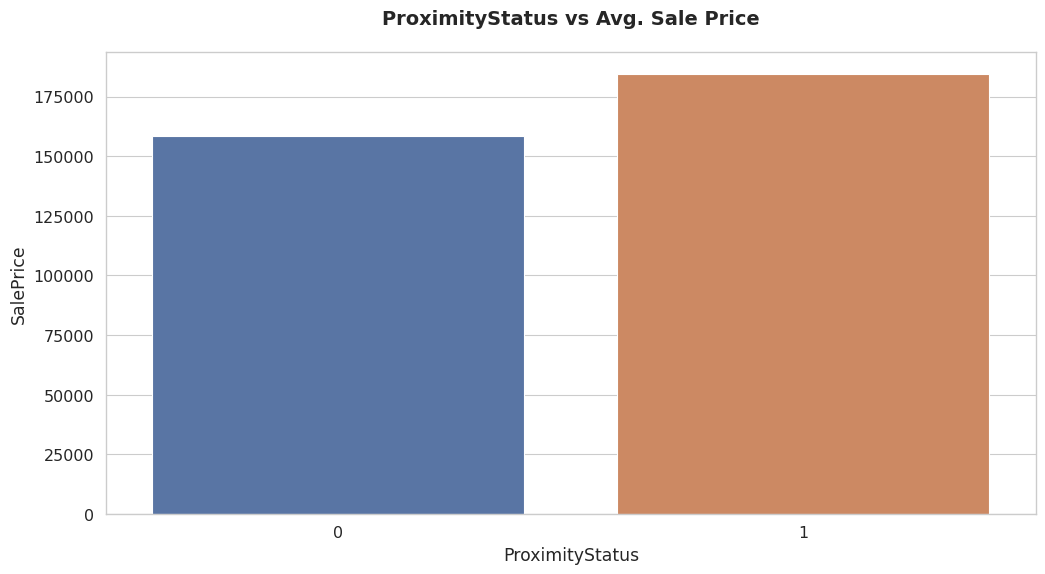

In [45]:
plt.figure(figsize = (12,6))
sns.barplot(x = 'ProximityStatus', y = 'SalePrice', data = train, estimator = 'mean', errorbar = None)
plt.title("ProximityStatus vs Avg. Sale Price", fontweight = "black", size = 14,pad = 20)

## Combination of Quality and Condition Columns

* Next, OverallQual and OverallCond are similar variables. So I merge them into one column with aveatge of these columns.
* On barplots below can be seen that trend is preserved.

In [46]:
train['CondQualAvg'] = ((train['OverallQual'] + train['OverallCond'])/2).astype(float)
test['CondQualAvg'] = ((test['OverallQual'] + test['OverallCond'])/2).astype(float)

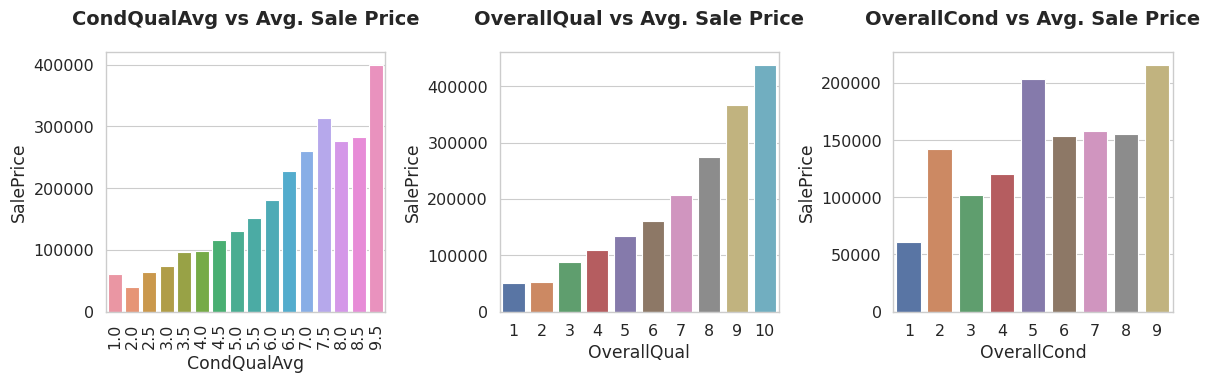

In [47]:
plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
sns.barplot(x = 'CondQualAvg', y = 'SalePrice', data = train, estimator = 'mean', errorbar = None)
plt.title("CondQualAvg vs Avg. Sale Price", fontweight = "black", size = 14,pad = 20)
plt.xticks(rotation = 90)

plt.subplot(1, 3, 2)
sns.barplot(x = 'OverallQual', y = 'SalePrice', data = train, estimator = 'mean', errorbar = None)
plt.title("OverallQual vs Avg. Sale Price", fontweight = "black", size = 14,pad = 20)

plt.subplot(1, 3, 3)
sns.barplot(x = 'OverallCond', y = 'SalePrice', data = train, estimator = 'mean', errorbar = None)
plt.title("OverallCond vs Avg. Sale Price", fontweight = "black", size = 14,pad = 20)
plt.tight_layout()

In [48]:
train.drop(columns=['OverallQual', 'OverallCond'],inplace=True)
test.drop(columns=['OverallQual', 'OverallCond'],inplace=True)

* The same procedure I did for ExterQual (Cond), BsmtQual (Cond) and GarageQual(Cond).
* Since the variables seem to be ordinal categories, I first grouped them into numbers.
* Barplots show some trend. I deleted quality and condition variables.

In [49]:
cond_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond']

for col in cond_cols:
    train[col] = train[col].replace(['Na', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], [0, 1, 2, 3, 4, 5]).astype(float)
    test[col] = test[col].replace(['Na', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], [0, 1, 2, 3, 4, 5]).astype(float)

In [50]:
train['ExterCondQualAvg'] = ((train['ExterQual'] + train['ExterCond'])/2).astype(float)
test['ExterCondQualAvg'] = ((test['ExterQual'] + test['ExterCond'])/2).astype(float)

train['BsmtCondQualAvg'] = ((train['BsmtQual'] + train['BsmtCond'])/2).astype(float)
test['BsmtCondQualAvg'] = ((test['BsmtQual'] + test['BsmtCond'])/2).astype(float)

train['GarageCondQualAvg'] = ((train['GarageQual'] + train['GarageCond'])/2).astype(float)
test['GarageCondQualAvg'] = ((test['GarageQual'] + test['GarageCond'])/2).astype(float)

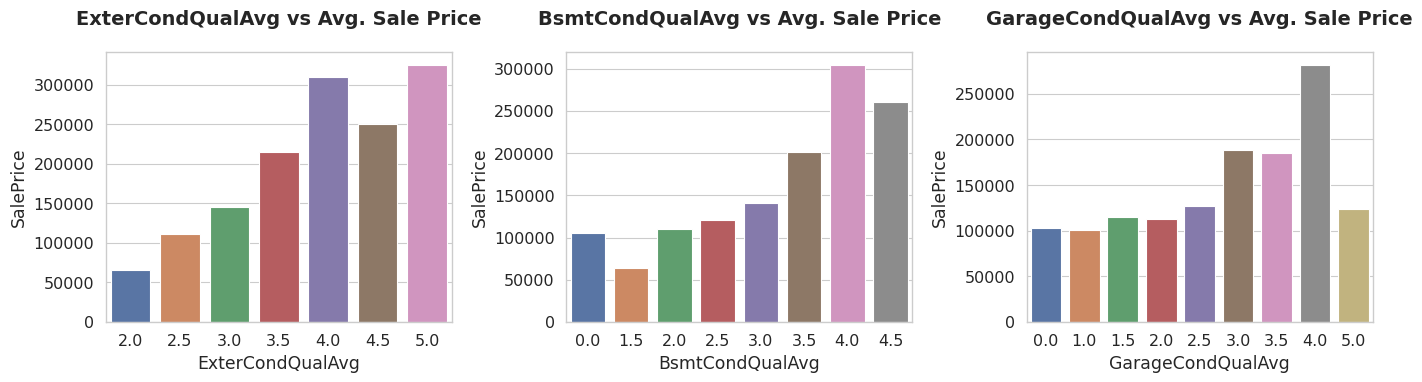

In [51]:
plt.figure(figsize=(14,4))

plt.subplot(1, 3, 1)
sns.barplot(x = 'ExterCondQualAvg', y = 'SalePrice', data = train, estimator = 'mean', errorbar = None)
plt.title("ExterCondQualAvg vs Avg. Sale Price", fontweight = "black", size = 14,pad = 20)

plt.subplot(1, 3, 2)
sns.barplot(x = 'BsmtCondQualAvg', y = 'SalePrice', data = train, estimator = 'mean', errorbar = None)
plt.title("BsmtCondQualAvg vs Avg. Sale Price", fontweight = "black", size = 14,pad = 20)

plt.subplot(1, 3, 3)
sns.barplot(x = 'GarageCondQualAvg', y = 'SalePrice', data = train, estimator = 'mean', errorbar = None)
plt.title("GarageCondQualAvg vs Avg. Sale Price", fontweight = "black", size = 14,pad = 20)
plt.tight_layout()

In [52]:
train.drop(columns=['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond'],inplace=True)
test.drop(columns=['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond'],inplace=True)

## **Square Feet Columns**

* First I will create binary variable for houses with and without basement.
* I also created new column to sumarize whole habitable space (Both floors and basement).

In [53]:
train["Bsmt"] = (train["TotalBsmtSF"]!=0).astype(int)
test["Bsmt"] = (test["TotalBsmtSF"]!=0).astype(int)

In [54]:
train['TotalSF'] = (train['BsmtFinSF1'] + train['BsmtFinSF2'] + train['1stFlrSF']
                              + train['2ndFlrSF'])
test['TotalSF'] = (test['BsmtFinSF1'] + test['BsmtFinSF2']
                             + test['1stFlrSF'] + test['2ndFlrSF'])

## **Bathroom Columns**

* There are lot of types of bathrooms in houses so I sum in one column.

In [55]:
train["TotalBath"] = (train["FullBath"] + (0.5 * train["HalfBath"]) + 
                               train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]))
test["TotalBath"] = (test["FullBath"] + (0.5 * test["HalfBath"]) + 
                               test["BsmtFullBath"] + (0.5 * test["BsmtHalfBath"]))

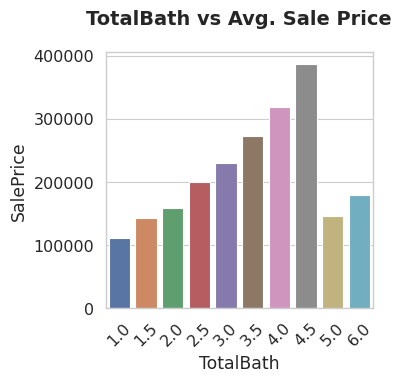

In [56]:
plt.figure(figsize=(4,4))

sns.barplot(x = 'TotalBath', y = 'SalePrice', data = train, estimator = 'mean', errorbar = None)
plt.title("TotalBath vs Avg. Sale Price", fontweight = "black", size = 14,pad = 20)
plt.xticks(rotation = 45)
plt.tight_layout()

## **Porch Columns**

* I combined all porch variables into one.
* Variables 3SsnPorch, EnclosedPorch, and ScreenPorch seems not important for predicting, I will dropped them

In [57]:
train['TotalPorchSF'] = (train['OpenPorchSF'] + train['3SsnPorch'] + train['EnclosedPorch']
                              + train['ScreenPorch'] + train['WoodDeckSF'])
test['TotalPorchSF'] = (test['OpenPorchSF'] + test['3SsnPorch'] + test['EnclosedPorch']
                              + test['ScreenPorch'] + test['WoodDeckSF'])

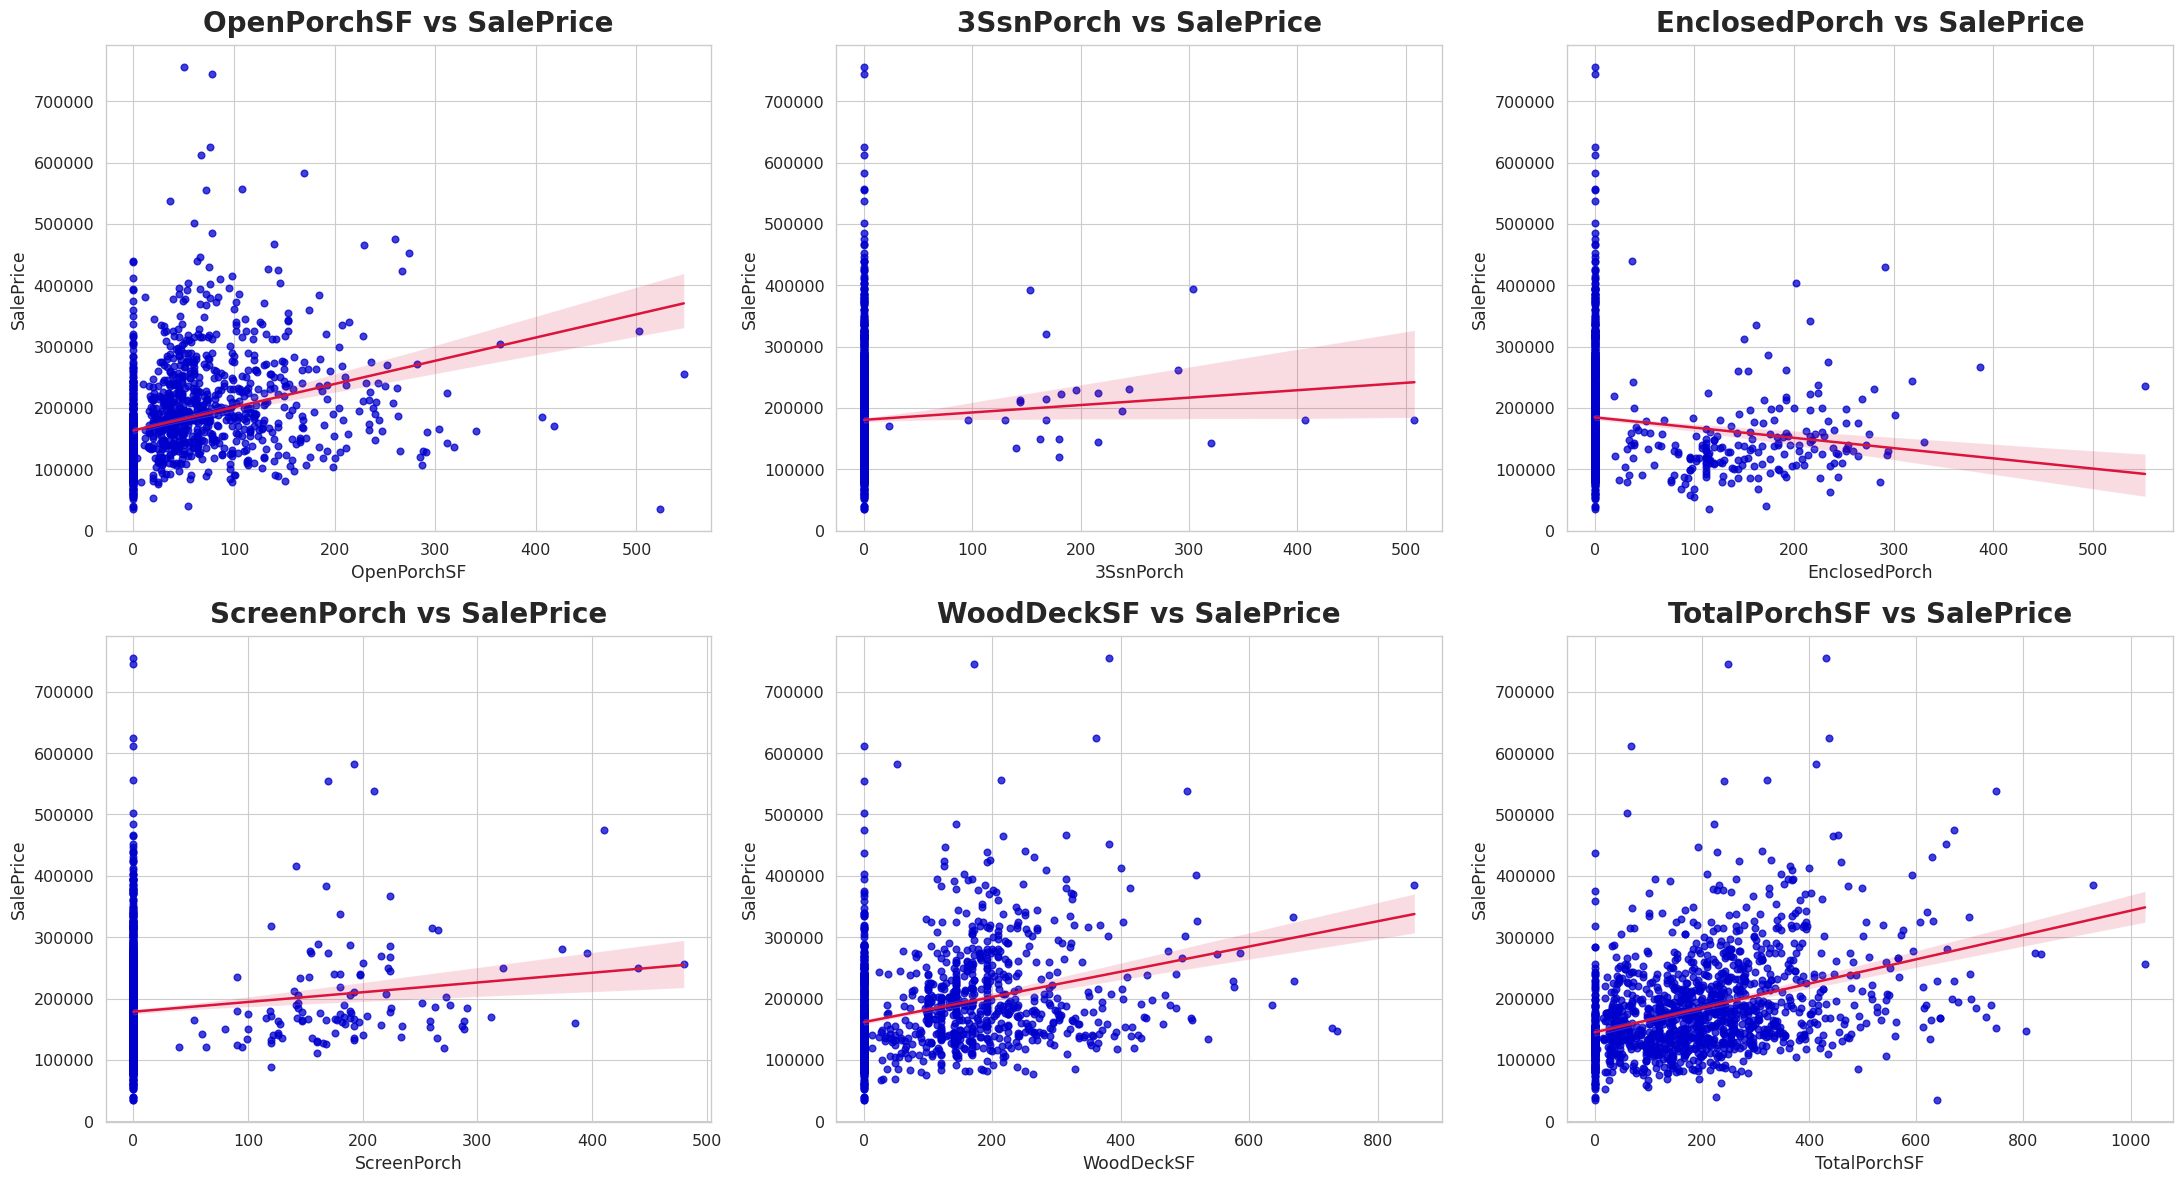

In [58]:
porch_cols = ["OpenPorchSF","3SsnPorch","EnclosedPorch","ScreenPorch","WoodDeckSF","TotalPorchSF"]

plt.figure(figsize=(22, 12))
for index, col in enumerate(porch_cols):
    plt.subplot(2, 3, index+1)
    sns.regplot(x = col, y = 'SalePrice', data = train,
                scatter_kws = {'color' : 'mediumblue', 'alpha' : 0.75},
                line_kws = {'color' : 'crimson'})
    plt.title(f"{col} vs SalePrice", pad=10, size=20, fontweight="black")
    plt.tight_layout()

In [59]:
train.drop(columns=['3SsnPorch', 'EnclosedPorch', 'ScreenPorch'],inplace=True)
test.drop(columns=['3SsnPorch', 'EnclosedPorch', 'ScreenPorch'],inplace=True)

## **Boolean Columns**

In [60]:
train["2ndFlr"] = (train['2ndFlrSF'] != 0).astype(int)
test["2ndFlr"] = (test['2ndFlrSF'] != 0).astype(int)

# **Data Preprocessing**

* Before splitting dataset I will perform one-hot encoding and label encoding.
* I have to split training dataset into train and validation set before scaling and encoding.

## One-Hot Encoding

In [61]:
cols = ['LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle',
                   'MasVnrType','Foundation', 'BsmtFinType1', 'BsmtFinType2', 'CentralAir',
                   'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType', 
                   'SaleCondition']

train = pd.get_dummies(train, columns = cols)
test = pd.get_dummies(test, columns = cols)

print(train.shape)
print(test.shape)

(1460, 132)
(1459, 130)


## Label Encoding

In [62]:
labels = {'BsmtExposure' : {'Na':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4},
         'Heating' : {'Floor':0, 'GasA':1, 'GasW':2, 'Grav':3, 'OthW':4, 'Wall':5},
         'HeatingQC' : {'Na':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
         'Electrical' : {'Mix':0, 'FuseP':1, 'FuseF':2, 'FuseA':3, 'SBrkr':4},
         'KitchenQual' : {'Na':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
         'Functional' : {'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7}}

for col in labels:
    le = LabelEncoder()
    le.fit(train[col].map(labels[col]))
    train[col] = le.transform(train[col].map(labels[col]))
    test[col] = le.transform(test[col].map(labels[col]))

## Splitting Into Train and Test Set

In [63]:
X = train.drop(['SalePrice', 'log_SalePrice'], axis = 1)
y_normal = train['SalePrice']
y = train['log_SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42, shuffle=True)

## Target Encoding

In [64]:
cols = ['MSZoning', 'HouseStyle', 'Neighborhood', 'Exterior1st', 'Exterior2nd']
    
for col in cols:
    category_target_median = X_train.join(y_train).groupby(col)['log_SalePrice'].median()
    X_train[col] = X_train[col].map(category_target_median)
    X_valid[col] = X_valid[col].map(category_target_median)
    test[col] = test[col].map(category_target_median)

## Robust Scaling

In [65]:
num_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
            'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 
            'WoodDeckSF', 'OpenPorchSF', 'TotalSF', 'TotalPorchSF']

rs = RobustScaler()
X_train[num_cols] = rs.fit_transform(X_train[num_cols])
X_valid[num_cols] = rs.transform(X_valid[num_cols])
test[num_cols] = rs.transform(test[num_cols])

# **Implementation of Machine Learning Models**

## **Model Selection**

* First I will choose best models for further usage.
* I will use cross-validation for this purposes.

In [66]:
train_MSE = []
test_MSE = []
train_RMSE = []
test_RMSE = []
train_MAE = []
test_MAE = []
train_MedAE = []
test_MedAE = []

In [67]:
def model_selection(model):
    cv_score = cross_validate(model, X_train, y_train, cv=5, 
                        scoring=('r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 
                                 'neg_mean_absolute_error', 'neg_median_absolute_error'),
                        return_train_score=True)
    
    #Appending mean values to lists and printing test values
    train_MSE.append(np.mean(cv_score['train_neg_mean_squared_error']))
    test_MSE.append(np.mean(cv_score['test_neg_mean_squared_error']))
    train_RMSE.append(np.mean(cv_score['train_neg_root_mean_squared_error']))
    test_RMSE.append(np.mean(cv_score['test_neg_root_mean_squared_error']))
    train_MAE.append(np.mean(cv_score['train_neg_mean_absolute_error']))
    test_MAE.append(np.mean(cv_score['test_neg_mean_absolute_error']))
    train_MedAE.append(np.mean(cv_score['train_neg_median_absolute_error']))
    test_MedAE.append(np.mean(cv_score['test_neg_median_absolute_error']))
    
    print(f"MSE of the {model} model is=>",np.mean(cv_score['test_neg_mean_squared_error']))
    print(f"RMSE of the {model} model is=>",np.mean(cv_score['test_neg_root_mean_squared_error']))
    print(f"MAE of the {model} model is=>",np.mean(cv_score['test_neg_mean_absolute_error']))
    print(f"MedAE of the {model} model is=>",np.mean(cv_score['test_neg_median_absolute_error']))
    
    #Comparing predicted values with actual values
    model.fit(X_train, y_train)
    y_train_pred= model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    
    plt.figure(figsize = (10, 5))    
    sns.scatterplot(x = y_train, y = y_train_pred, color = 'dodgerblue', label = 'Train')
    sns.scatterplot(x = y_valid, y = y_valid_pred, color = 'crimson', label = 'Valid')
    plt.plot([10, 14], [10, 14], c = 'black')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.title('Scatter Plot of Predicted vs Actual values ',fontweight="black",size=20,pad=10)
    

# Linear Regression

MSE of the LinearRegression() model is=> -0.02213504204980672
RMSE of the LinearRegression() model is=> -0.1459015694414066
MAE of the LinearRegression() model is=> -0.09544602456575804
MedAE of the LinearRegression() model is=> -0.07111300561156675


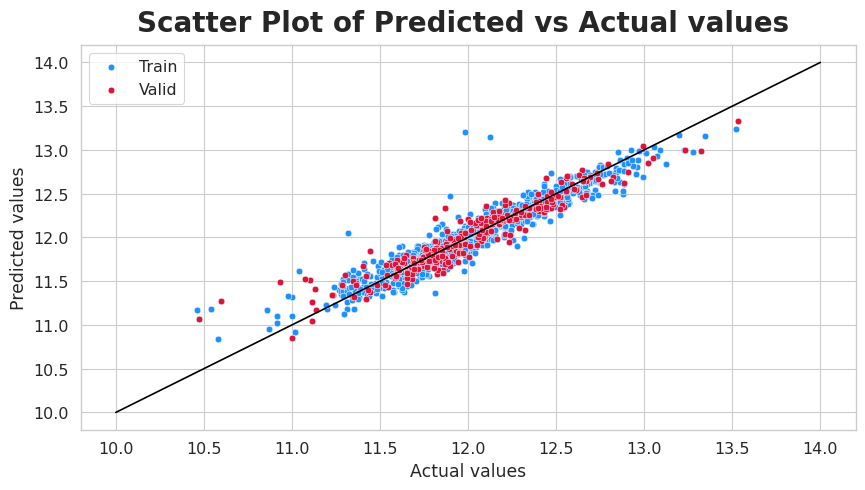

In [68]:
model_selection(LinearRegression())

# Support Vector Regression

MSE of the SVR() model is=> -0.051311348173518345
RMSE of the SVR() model is=> -0.2252810008040907
MAE of the SVR() model is=> -0.16310561051711675
MedAE of the SVR() model is=> -0.11796653794009267


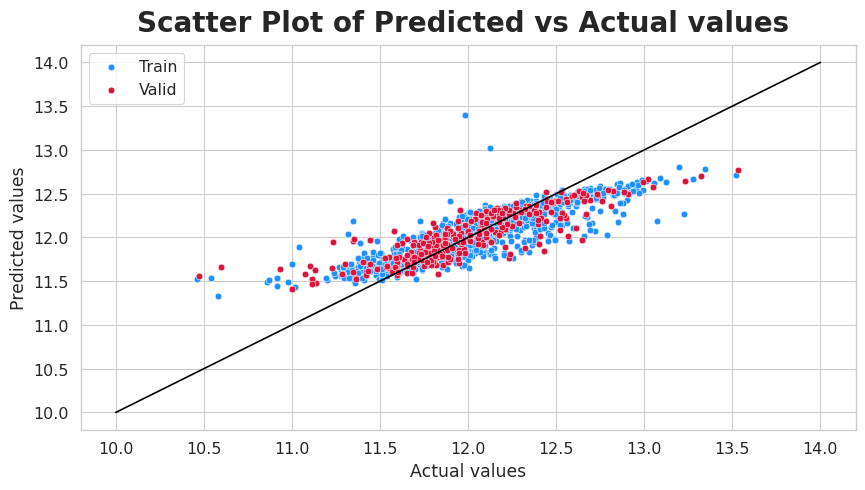

In [69]:
model_selection(SVR())

# Random Forest

MSE of the RandomForestRegressor() model is=> -0.018602778800295126
RMSE of the RandomForestRegressor() model is=> -0.13538707158522092
MAE of the RandomForestRegressor() model is=> -0.09511442194044166
MedAE of the RandomForestRegressor() model is=> -0.0667746442934563


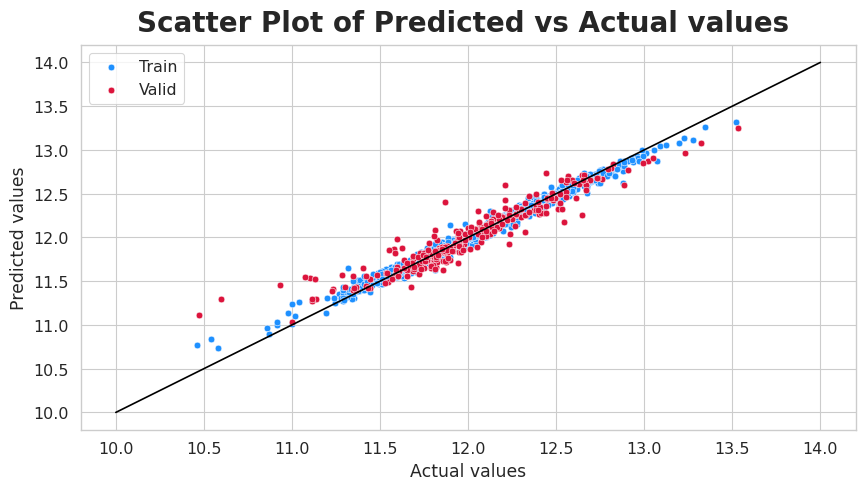

In [70]:
model_selection(RandomForestRegressor())

# Gradient Boost

MSE of the GradientBoostingRegressor() model is=> -0.016401343884844384
RMSE of the GradientBoostingRegressor() model is=> -0.12767746284296747
MAE of the GradientBoostingRegressor() model is=> -0.08913169371412487
MedAE of the GradientBoostingRegressor() model is=> -0.06297995051411025


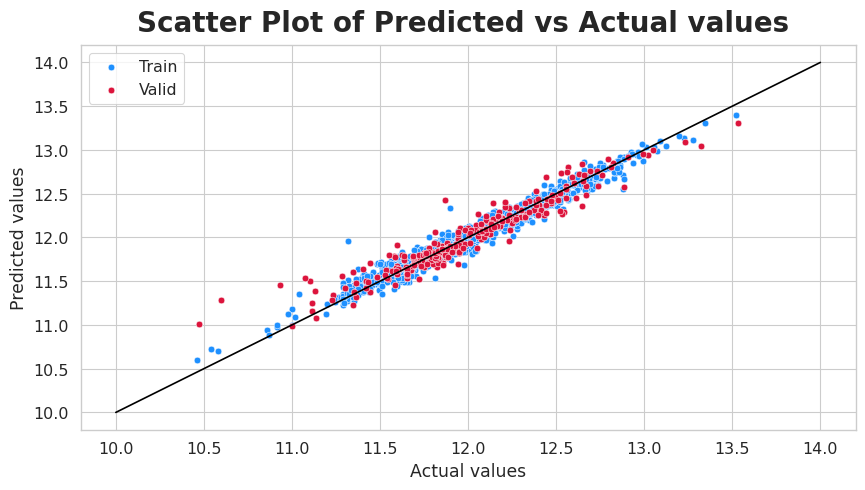

In [71]:
model_selection(GradientBoostingRegressor())

# AdaBoost

MSE of the AdaBoostRegressor() model is=> -0.026508237440047787
RMSE of the AdaBoostRegressor() model is=> -0.16206411204142906
MAE of the AdaBoostRegressor() model is=> -0.12215497330617442
MedAE of the AdaBoostRegressor() model is=> -0.10049459422160609


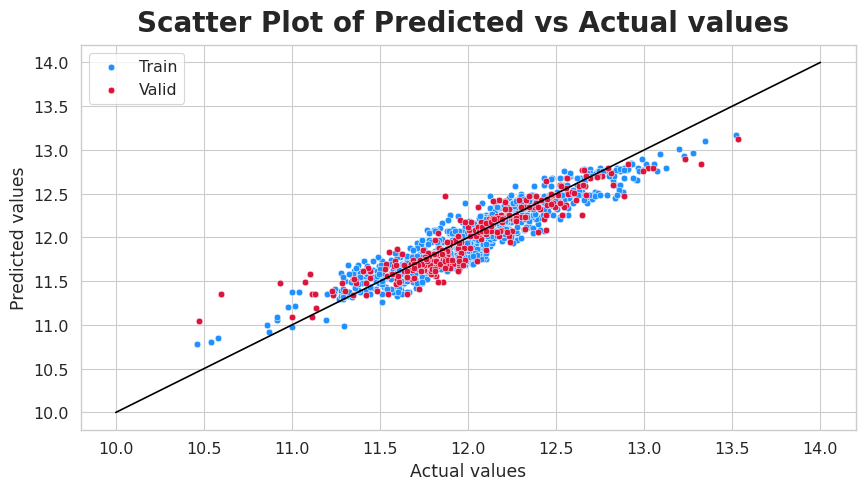

In [72]:
model_selection(AdaBoostRegressor())

# CatBoost

MSE of the <catboost.core.CatBoostRegressor object at 0x7b76c1327850> model is=> -0.014813336531809648
RMSE of the <catboost.core.CatBoostRegressor object at 0x7b76c1327850> model is=> -0.12088553544487976
MAE of the <catboost.core.CatBoostRegressor object at 0x7b76c1327850> model is=> -0.0821695657078801
MedAE of the <catboost.core.CatBoostRegressor object at 0x7b76c1327850> model is=> -0.05791923387132094


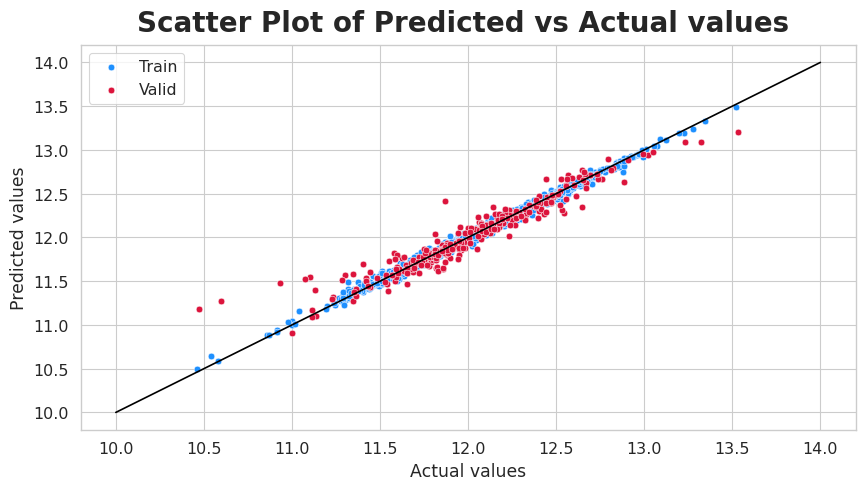

In [73]:
model_selection(CatBoostRegressor(verbose=False))

# XGBoost

MSE of the XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) model is=> -0.02015350258312412
RMSE of the XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_

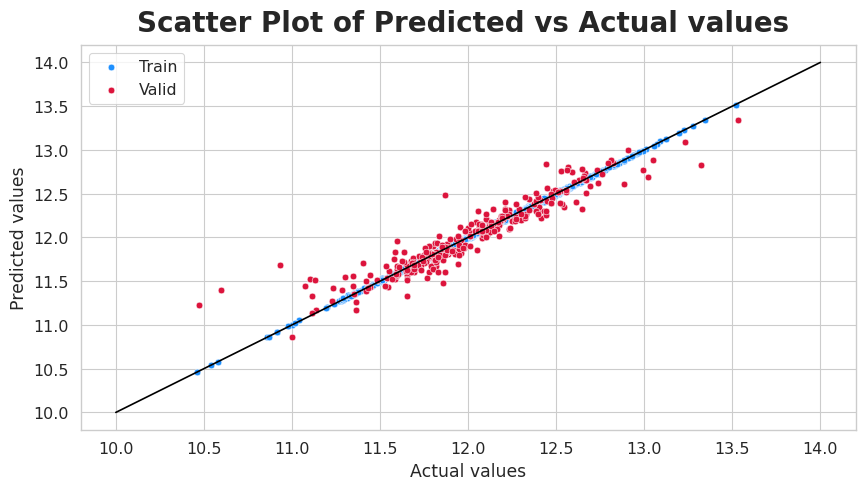

In [74]:
model_selection(xgb.XGBRegressor())

# Performance Comparison

In [75]:
models = ['Linear Regression', 'SVR', 'Random Forest', 'Gradient Boost',
         'AdaBoost', 'CatBoost', 'XGBoost']


test_MSE = np.abs(test_MSE)
train_MSE = np.abs(train_MSE)
test_RMSE = np.abs(test_RMSE)
train_RMSE = np.abs(train_RMSE)
test_MAE = np.abs(test_MAE)
train_MAE = np.abs(train_MAE)
test_MedAE = np.abs(test_MedAE)
train_MedAE = np.abs(train_MedAE)

compare_df = pd.DataFrame({'Model' : models, 'MSE train' : train_MSE, 'MSE test' : test_MSE, 
                           'RMSE train' : train_RMSE, 'RMSE test' : test_RMSE, 'MAE train' : train_MAE,
                          'MAE test' : test_MAE, 'MedAE train' : train_MedAE, 'MedAE test' : test_MedAE})

In [76]:
compare_df

Model  MSE train  MSE test  RMSE train  RMSE test  MAE train  \
0  Linear Regression   0.013752  0.022135    0.117106   0.145902   0.080907   
1                SVR   0.047940  0.051311    0.218899   0.225281   0.157678   
2      Random Forest   0.002692  0.018603    0.051845   0.135387   0.035456   
3     Gradient Boost   0.005141  0.016401    0.071681   0.127677   0.053374   
4           AdaBoost   0.018807  0.026508    0.137110   0.162064   0.110348   
5           CatBoost   0.000766  0.014813    0.027663   0.120886   0.021534   
6            XGBoost   0.000021  0.020154    0.004558   0.141716   0.003221   

   MAE test  MedAE train  MedAE test  
0  0.095446     0.060757    0.071113  
1  0.163106     0.111271    0.117967  
2  0.095114     0.024545    0.066775  
3  0.089132     0.041834    0.062980  
4  0.122155     0.092975    0.100495  
5  0.082170     0.017077    0.057919  
6  0.098106     0.002204    0.070314

* Plots for predicted and actual values display that all models somehow underestimate expensive houses and overestimate cheap houses.
* All models except SVR tends to overfit. However, SVR is the worst model.
* Best models seems to be CatBoost and Gradient Boost.
* Further I will use these two models and XGBoost, Random Forest and Linear Regression (as benchmark).

## **Hyperparameter Tuning**

* I will tune hyperparameters of selected models and perform similar procedure as above. I will also check feature importances and base on it I will select features to final model training.

In [77]:
train_MSE_tune = []
test_MSE_tune = []
train_RMSE_tune = []
test_RMSE_tune = []
train_MAE_tune = []
test_MAE_tune = []
train_MedAE_tune = []
test_MedAE_tune = []
features_count = {}

In [78]:
def model_plots_lr(lr, model):
    y_train_pred= lr.predict(X_train)
    y_valid_pred = lr.predict(X_valid)
    
    #Appending mean values to lists and printing test values
    train_MSE_tune.append(mean_squared_error(y_train, y_train_pred))
    test_MSE_tune.append(mean_squared_error(y_valid, y_valid_pred))
    train_RMSE_tune.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    test_RMSE_tune.append(np.sqrt(mean_squared_error(y_valid, y_valid_pred)))
    train_MAE_tune.append(mean_absolute_error(y_train, y_train_pred))
    test_MAE_tune.append(mean_absolute_error(y_valid, y_valid_pred))
    train_MedAE_tune.append(median_absolute_error(y_train, y_train_pred))
    test_MedAE_tune.append(median_absolute_error(y_valid, y_valid_pred))
    
    print(f"MSE of the {model} model is=>",mean_squared_error(y_valid, y_valid_pred))
    print(f"RMSE of the {model} model is=>",np.sqrt(mean_squared_error(y_valid, y_valid_pred)))
    print(f"MAE of the {model} model is=>",mean_absolute_error(y_valid, y_valid_pred))
    print(f"MedAE of the {model} model is=>",median_absolute_error(y_valid, y_valid_pred))
    
    #Plotting Predicted vs Actual values
    plt.figure(figsize = (10, 5))    
    sns.scatterplot(x = y_train, y = y_train_pred, color = 'dodgerblue', label = 'Train')
    sns.scatterplot(x = y_valid, y = y_valid_pred, color = 'crimson', label = 'Valid')
    plt.plot([10, 14], [10, 14], c = 'black')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.title('Scatter Plot of Predicted vs Actual values ',fontweight="black",size=20,pad=10)

In [79]:
def model_plots(bayes, model):
    print(bayes.best_params_)
    print(bayes.best_score_)
    
    best = bayes.best_estimator_
    y_train_pred= best.predict(X_train)
    y_valid_pred = best.predict(X_valid)
    
    #Appending mean values to lists and printing test values
    train_MSE_tune.append(mean_squared_error(y_train, y_train_pred))
    test_MSE_tune.append(mean_squared_error(y_valid, y_valid_pred))
    train_RMSE_tune.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    test_RMSE_tune.append(np.sqrt(mean_squared_error(y_valid, y_valid_pred)))
    train_MAE_tune.append(mean_absolute_error(y_train, y_train_pred))
    test_MAE_tune.append(mean_absolute_error(y_valid, y_valid_pred))
    train_MedAE_tune.append(median_absolute_error(y_train, y_train_pred))
    test_MedAE_tune.append(median_absolute_error(y_valid, y_valid_pred))
    
    print(f"MSE of the {model} model is=>",mean_squared_error(y_valid, y_valid_pred))
    print(f"RMSE of the {model} model is=>",np.sqrt(mean_squared_error(y_valid, y_valid_pred)))
    print(f"MAE of the {model} model is=>",mean_absolute_error(y_valid, y_valid_pred))
    print(f"MedAE of the {model} model is=>",median_absolute_error(y_valid, y_valid_pred))
    
    #Plotting Predicted vs Actual values
    plt.figure(figsize = (10, 5))    
    sns.scatterplot(x = y_train, y = y_train_pred, color = 'dodgerblue', label = 'Train')
    sns.scatterplot(x = y_valid, y = y_valid_pred, color = 'crimson', label = 'Valid')
    plt.plot([10, 14], [10, 14], c = 'black')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.title('Scatter Plot of Predicted vs Actual values ',fontweight="black",size=20,pad=10)
    
    #Plotting Feature Importances
    importances = best.feature_importances_
    importances_df = pd.DataFrame({'Features' : X_train.columns, 'Importances' : importances})

    importances_df = importances_df.sort_values(by = ['Importances'], ascending = False)
    top_features = importances_df[importances_df['Importances'] >= 0.01]

    plt.figure(figsize = (10,8))
    sns.barplot(x = 'Importances', y = 'Features', data = top_features)
    plt.title('FEATURE IMPORTANCE', fontweight = 'black')
    
    #Counting features
    feat = top_features['Features']
    
    for entry in feat:

        if entry in features_count.keys():
            features_count[entry] += 1
        else:
            features_count[entry] = features_count.get(entry, 0) + 1

In [80]:
def model_plots_cat(bayes, model):
    print(bayes.best_params_)
    print(bayes.best_score_)
    
    best = bayes.best_estimator_
    y_train_pred= best.predict(X_train)
    y_valid_pred = best.predict(X_valid)
    
    #Appending mean values to lists and printing test values
    train_MSE_tune.append(mean_squared_error(y_train, y_train_pred))
    test_MSE_tune.append(mean_squared_error(y_valid, y_valid_pred))
    train_RMSE_tune.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    test_RMSE_tune.append(np.sqrt(mean_squared_error(y_valid, y_valid_pred)))
    train_MAE_tune.append(mean_absolute_error(y_train, y_train_pred))
    test_MAE_tune.append(mean_absolute_error(y_valid, y_valid_pred))
    train_MedAE_tune.append(median_absolute_error(y_train, y_train_pred))
    test_MedAE_tune.append(median_absolute_error(y_valid, y_valid_pred))
    
    print(f"MSE of the {model} model is=>",mean_squared_error(y_valid, y_valid_pred))
    print(f"RMSE of the {model} model is=>",np.sqrt(mean_squared_error(y_valid, y_valid_pred)))
    print(f"MAE of the {model} model is=>",mean_absolute_error(y_valid, y_valid_pred))
    print(f"MedAE of the {model} model is=>",median_absolute_error(y_valid, y_valid_pred))
    
    #Plotting Predicted vs Actual values
    plt.figure(figsize = (10, 5))    
    sns.scatterplot(x = y_train, y = y_train_pred, color = 'dodgerblue', label = 'Train')
    sns.scatterplot(x = y_valid, y = y_valid_pred, color = 'crimson', label = 'Valid')
    plt.plot([10, 14], [10, 14], c = 'black')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.title('Scatter Plot of Predicted vs Actual values ',fontweight="black",size=20,pad=10)
    
    #Plotting Feature Importances
    importances = best.feature_importances_
    importances_df = pd.DataFrame({'Features' : X_train.columns, 'Importances' : importances})

    importances_df = importances_df.sort_values(by = ['Importances'], ascending = False)
    top_features = importances_df[importances_df['Importances'] >= 1]

    plt.figure(figsize = (10,8))
    sns.barplot(x = 'Importances', y = 'Features', data = top_features)
    plt.title('FEATURE IMPORTANCE', fontweight = 'black')
    
    #Counting features
    feat = top_features['Features']
    
    for entry in feat:

        if entry in features_count.keys():
            features_count[entry] += 1
        else:
            features_count[entry] = features_count.get(entry, 0) + 1

## Linear Regression

MSE of the LinearRegression() model is=> 0.018890068363645488
RMSE of the LinearRegression() model is=> 0.137441145089982
MAE of the LinearRegression() model is=> 0.09835611590467473
MedAE of the LinearRegression() model is=> 0.07139670939135279


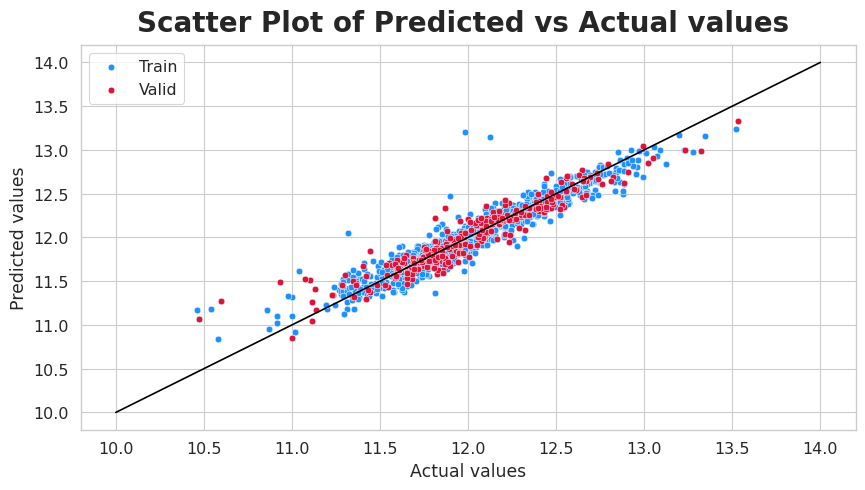

In [81]:
lr = LinearRegression()
lr.fit(X_train, y_train)

model_plots_lr(lr,lr)

## Random Forest

In [82]:
params_rf = {'n_estimators' : Integer(10, 500), 
          'max_depth' : Integer(1, 30), 
          'min_samples_split' : Real(0.01, 0.9),
          'min_samples_leaf' : Real(0.01,0.9), 
          'max_features' : Real(0.1, 0.9), 
          'bootstrap' : Categorical([True, False]) 
          }

rf = RandomForestRegressor(random_state = 42)

bayes_rf = BayesSearchCV(rf, params_rf, scoring = 'neg_root_mean_squared_error', n_iter = 50, 
                      cv = 5, random_state = 42, n_jobs = -1)
bayes_rf.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


BayesSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
              random_state=42, scoring='neg_root_mean_squared_error',
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'max_depth': Integer(low=1, high=30, prior='uniform', transform='normalize'),
                             'max_features': Real(low=0.1, high=0.9, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Real(low=0.01, high=0.9, prior='uniform', transform='normalize'),
                             'min_samples_split': Real(low=0.01, high=0.9, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=500, prior='uniform', transform='normalize')})

OrderedDict([('bootstrap', False), ('max_depth', 30), ('max_features', 0.1), ('min_samples_leaf', 0.01), ('min_samples_split', 0.01), ('n_estimators', 500)])
-0.14391121013869904
MSE of the RandomForestRegressor(random_state=42) model is=> 0.026325388663020047
RMSE of the RandomForestRegressor(random_state=42) model is=> 0.16225100512175586
MAE of the RandomForestRegressor(random_state=42) model is=> 0.10299572553458264
MedAE of the RandomForestRegressor(random_state=42) model is=> 0.060266083494671996


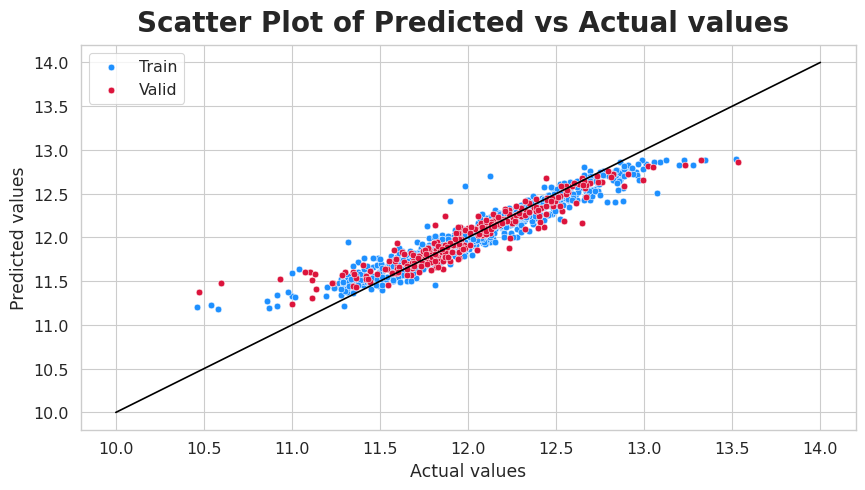

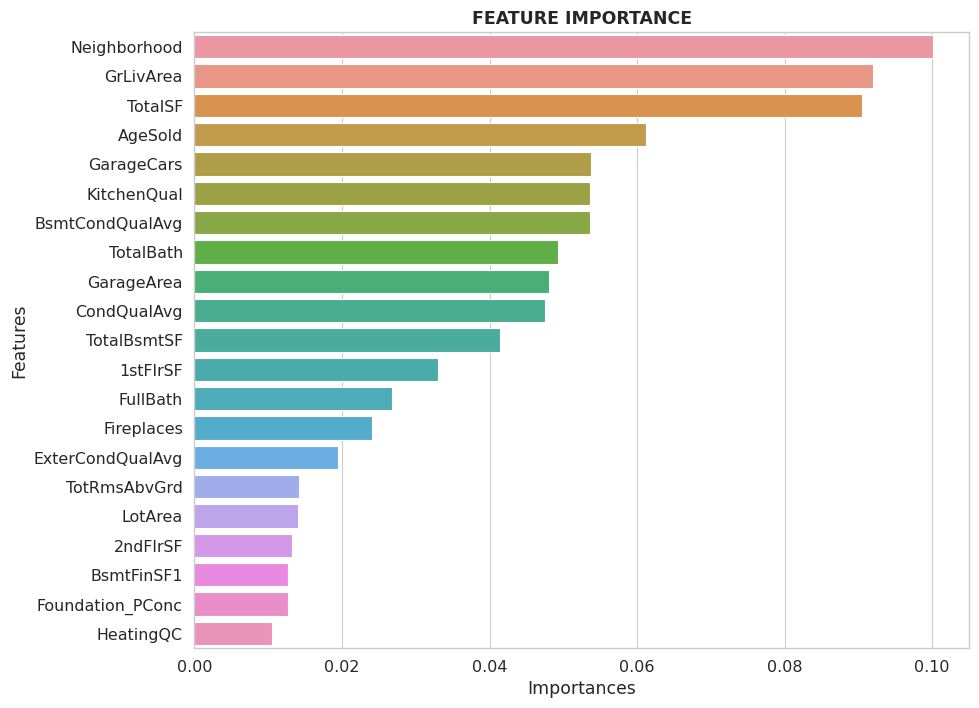

In [83]:
model_plots(bayes_rf, rf)

## Gradient Boost

In [84]:
params_gb = {'n_estimators' : Integer(10, 500), 
          'max_depth' : Integer(1, 30), 
          'min_samples_split' : Real(0.01, 1.0),
          'min_samples_leaf' : Integer(1,1000), 
          'max_features' : Real(0.1, 1.0), 
          'subsample' : Real(0.01, 1.0), 
          'learning_rate' : Real(0.01, 1.0)
          }

gb = GradientBoostingRegressor(random_state = 42, n_iter_no_change = 8)

bayes_gb = BayesSearchCV(gb, params_gb, scoring = 'neg_root_mean_squared_error', n_iter = 50, 
                      cv = 5, random_state = 42, n_jobs = -1)
bayes_gb.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=GradientBoostingRegressor(n_iter_no_change=8,
                                                  random_state=42),
              n_jobs=-1, random_state=42, scoring='neg_root_mean_squared_error',
              search_spaces={'learning_rate': Real(low=0.01, high=1.0, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=30, prior='uniform', transform='normalize'),
                             'max_features': Real(low=0.1, h...'uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=1, high=1000, prior='uniform', transform='normalize'),
                             'min_samples_split': Real(low=0.01, high=1.0, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=500, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.01, high=1.0, prior='uniform', transform='normalize')})

OrderedDict([('learning_rate', 0.01), ('max_depth', 30), ('max_features', 0.2778957373300106), ('min_samples_leaf', 26), ('min_samples_split', 0.01), ('n_estimators', 474), ('subsample', 0.7479561172361802)])
-0.13191100744805215
MSE of the GradientBoostingRegressor(n_iter_no_change=8, random_state=42) model is=> 0.020872232160144753
RMSE of the GradientBoostingRegressor(n_iter_no_change=8, random_state=42) model is=> 0.14447225394567897
MAE of the GradientBoostingRegressor(n_iter_no_change=8, random_state=42) model is=> 0.09171402945493906
MedAE of the GradientBoostingRegressor(n_iter_no_change=8, random_state=42) model is=> 0.059980843350303736


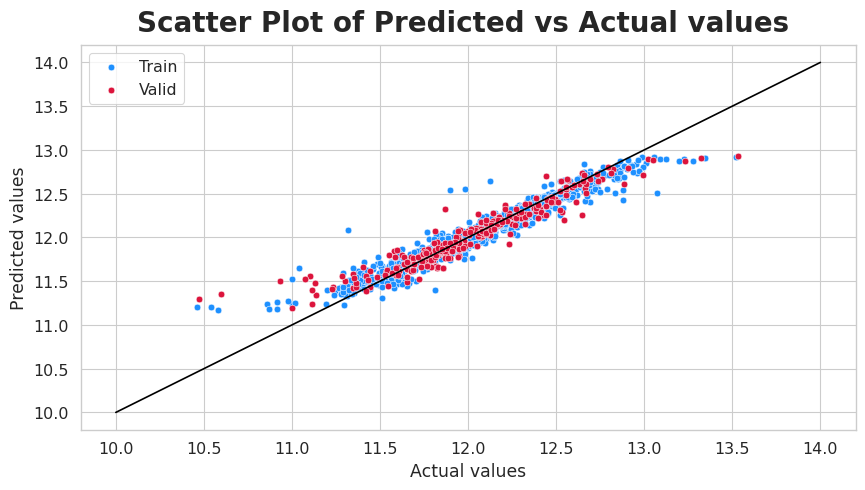

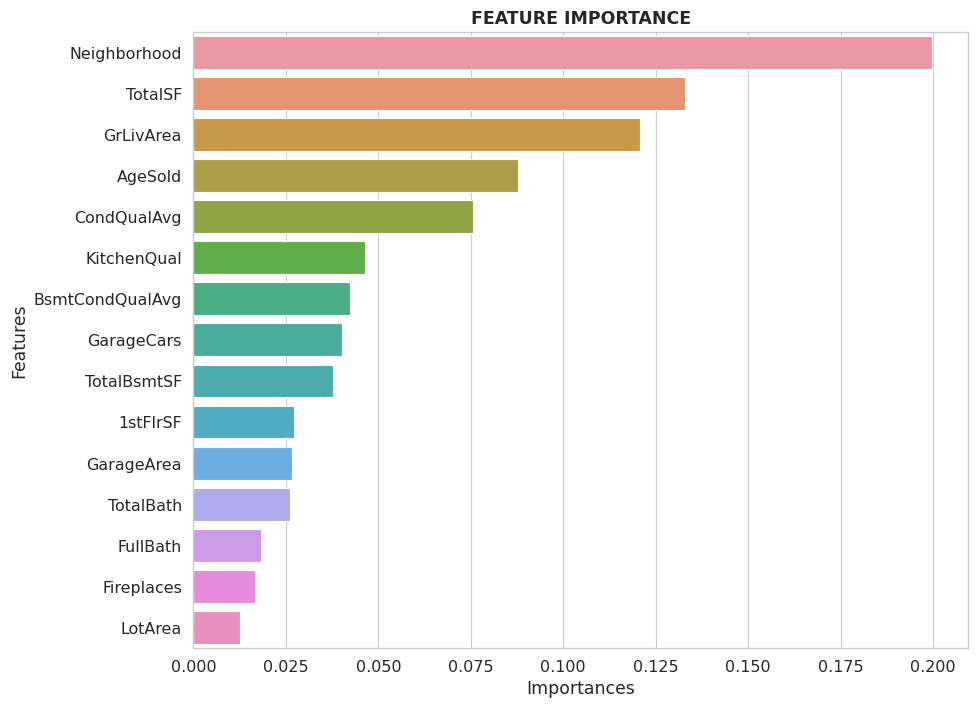

In [85]:
model_plots(bayes_gb, gb)

## CatBoost

In [86]:
params_cat = {'iterations' : Integer(10, 500), 
          'depth' : Integer(1, 16), 
          'colsample_bylevel' : Real(0.01, 1.0),
          'min_data_in_leaf' : Integer(1, 1000), 
          'l2_leaf_reg' : Real(0.1, 1.0), 
          'learning_rate' : Real(0.01, 1.0), 
          'random_strength' : Real(0.01, 10.0)
          }

cat = CatBoostRegressor(random_state = 42, verbose = False)

bayes_cat = BayesSearchCV(cat, params_cat, scoring = 'neg_root_mean_squared_error', n_iter = 50, 
                      cv = 5, random_state = 42, n_jobs = -1)
bayes_cat.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], early_stopping_rounds = 8, 
              verbose_eval = False)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


BayesSearchCV(cv=5,
              estimator=<catboost.core.CatBoostRegressor object at 0x7b76c12af880>,
              n_jobs=-1, random_state=42, scoring='neg_root_mean_squared_error',
              search_spaces={'colsample_bylevel': Real(low=0.01, high=1.0, prior='uniform', transform='normalize'),
                             'depth': Integer(low=1, high=16, prior='uniform', transform='normalize'),
                             'iterations': Integer(low=10, high=50...'uniform', transform='normalize'),
                             'l2_leaf_reg': Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.01, high=1.0, prior='uniform', transform='normalize'),
                             'min_data_in_leaf': Integer(low=1, high=1000, prior='uniform', transform='normalize'),
                             'random_strength': Real(low=0.01, high=10.0, prior='uniform', transform='normalize')})

OrderedDict([('colsample_bylevel', 0.23152006242194892), ('depth', 6), ('iterations', 500), ('l2_leaf_reg', 0.8955209244100428), ('learning_rate', 0.08651413463958467), ('min_data_in_leaf', 134), ('random_strength', 3.43820098331904)])
-0.1256825812624999
MSE of the <catboost.core.CatBoostRegressor object at 0x7b76c12af880> model is=> 0.01747671685947826
RMSE of the <catboost.core.CatBoostRegressor object at 0x7b76c12af880> model is=> 0.13219953426346956
MAE of the <catboost.core.CatBoostRegressor object at 0x7b76c12af880> model is=> 0.0873425769089416
MedAE of the <catboost.core.CatBoostRegressor object at 0x7b76c12af880> model is=> 0.05929087195731508


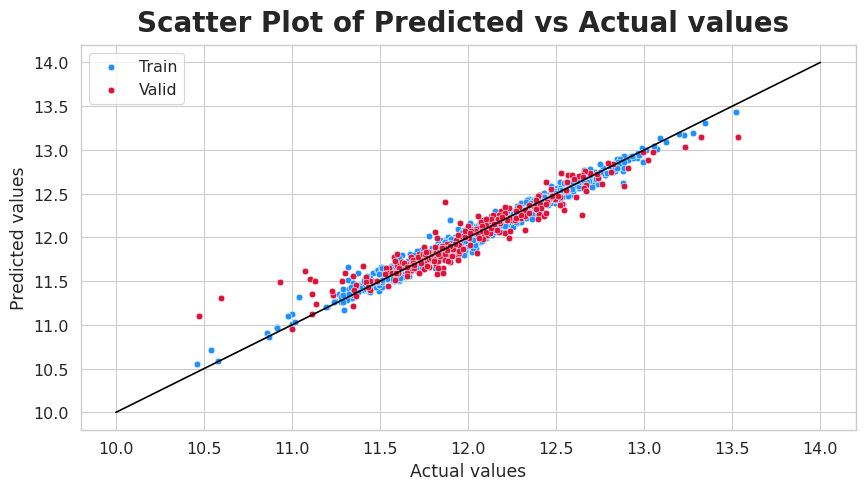

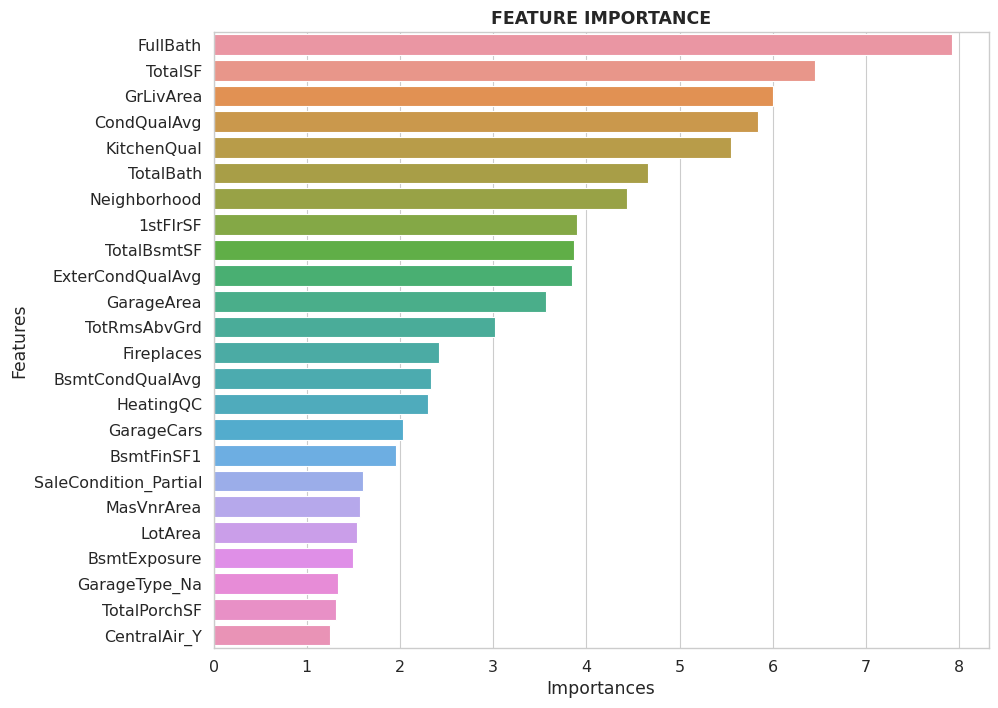

In [87]:
model_plots_cat(bayes_cat, cat)

## XGBoost

In [88]:
params_xgb = {'n_estimators' : Integer(10, 500), 
          'max_depth' : Integer(1, 30), 
          'colsample_bytree' : Real(0.01, 1.0),
          'lambda' : Real(0.01,1.0), 
          'alpha' : Real(0.1, 1.0), 
          'subsample' : Real(0.01, 1.0), 
          'eta' : Real(0.01, 1.0), 
          'gamma' : Real(0.01, 10.0)
          }

XGb = xgb.XGBRegressor(random_state = 42, verbosity = 0, early_stopping_rounds = 8)

bayes_xgb = BayesSearchCV(XGb, params_xgb, scoring = 'neg_root_mean_squared_error', n_iter = 50, 
                      cv = 5, random_state = 42, n_jobs = -1, verbose = False)
bayes_xgb.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], verbose = 0)

BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=8,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                             'gamma': Real(low=0.01, high=10.0, prior='uniform', transform='normalize'),
                             'lambda': Real(low=0.01, high=1.0, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=30, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=500, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.01, high=1.0, prior='uniform', transform='normalize')},
              verbose=False)

OrderedDict([('alpha', 0.1), ('colsample_bytree', 0.8993208841123664), ('eta', 0.1350074423758226), ('gamma', 0.01), ('lambda', 0.4077521202480635), ('max_depth', 22), ('n_estimators', 256), ('subsample', 1.0)])
-0.1282310828119247
MSE of the XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=8,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...) model is=> 0.01752316

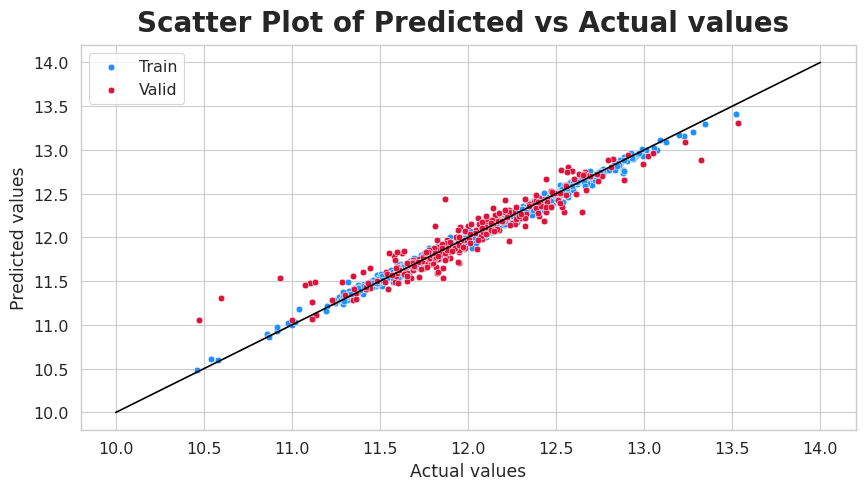

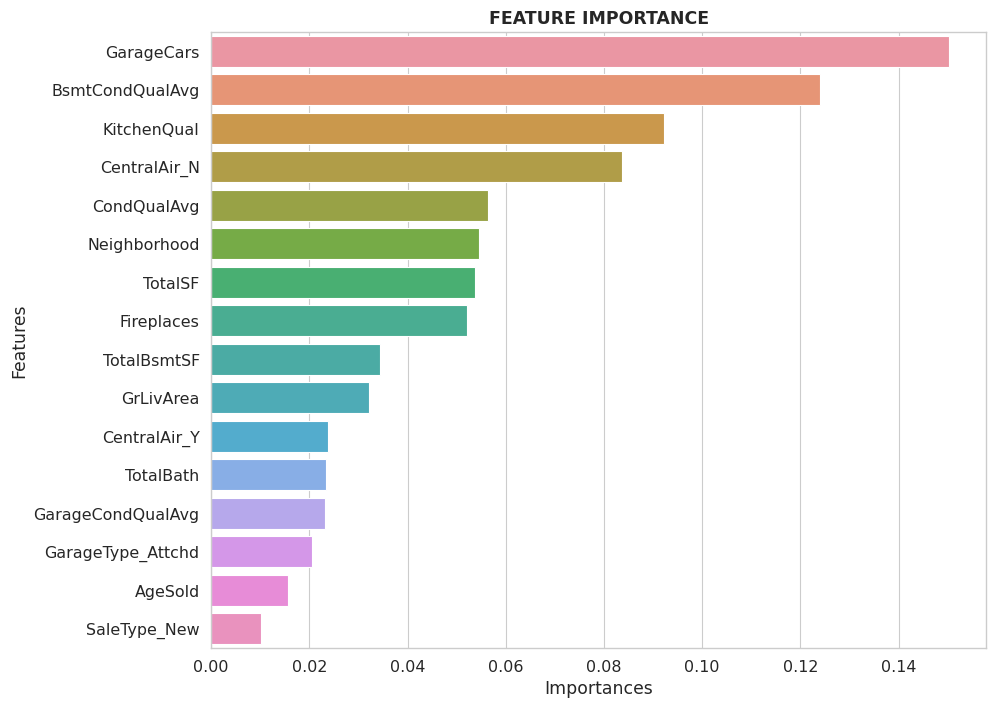

In [89]:
model_plots(bayes_xgb, XGb)

In [90]:
models = ['Linear Regression', 'Random Forest', 'Gradient Boost',
          'CatBoost', 'XGBoost']


test_MSE_tune = np.abs(test_MSE_tune)
train_MSE_tune = np.abs(train_MSE_tune)
test_RMSE_tune = np.abs(test_RMSE_tune)
train_RMSE_tune = np.abs(train_RMSE_tune)
test_MAE_tune = np.abs(test_MAE_tune)
train_MAE_tune = np.abs(train_MAE_tune)
test_MedAE_tune = np.abs(test_MedAE_tune)
train_MedAE_tune = np.abs(train_MedAE_tune)

tune_df = pd.DataFrame({'Model' : models, 'MSE train' : train_MSE_tune, 'MSE test' : test_MSE_tune, 
                           'RMSE train' : train_RMSE_tune, 'RMSE test' : test_RMSE_tune, 
                           'MAE train' : train_MAE_tune, 'MAE test' : test_MAE_tune, 
                           'MedAE train' : train_MedAE_tune, 'MedAE test' : test_MedAE_tune})

In [91]:
tune_df

Model  MSE train  MSE test  RMSE train  RMSE test  MAE train  \
0  Linear Regression   0.014431  0.018890    0.120129   0.137441   0.082294   
1      Random Forest   0.013651  0.026325    0.116836   0.162251   0.076036   
2     Gradient Boost   0.011764  0.020872    0.108463   0.144472   0.069583   
3           CatBoost   0.003363  0.017477    0.057994   0.132200   0.044162   
4            XGBoost   0.001330  0.017523    0.036465   0.132375   0.028094   

   MAE test  MedAE train  MedAE test  
0  0.098356     0.061587    0.071397  
1  0.102996     0.048417    0.060266  
2  0.091714     0.046388    0.059981  
3  0.087343     0.035836    0.059291  
4  0.087799     0.023069    0.058950

In [92]:
features_df = pd.DataFrame.from_dict(features_count, columns = ['Count'], orient = 'index')
features_df = features_df.sort_values('Count', ascending = False)
features_df

Count
Neighborhood               4
BsmtCondQualAvg            4
GrLivArea                  4
Fireplaces                 4
TotalBsmtSF                4
TotalBath                  4
CondQualAvg                4
KitchenQual                4
GarageCars                 4
TotalSF                    4
GarageArea                 3
1stFlrSF                   3
FullBath                   3
AgeSold                    3
LotArea                    3
BsmtFinSF1                 2
CentralAir_Y               2
HeatingQC                  2
TotRmsAbvGrd               2
ExterCondQualAvg           2
Foundation_PConc           1
2ndFlrSF                   1
SaleCondition_Partial      1
MasVnrArea                 1
BsmtExposure               1
GarageType_Na              1
TotalPorchSF               1
CentralAir_N               1
GarageCondQualAvg          1
GarageType_Attchd          1
SaleType_New               1

* All models perform better than with tuned hyperparameters. Best models are CatBoost and XGBoost.
* 10 Features are important for all models. I will use all these features which are important above threshold (0.01) for at least one model.

# **Final Predictions and Submission**

In [93]:
test

MSSubClass   MSZoning  LotFrontage   LotArea  Neighborhood  HouseStyle  \
0             20  11.849398     0.578947  0.491642     11.863582   11.964001   
1             20  12.070825     0.631579  1.134764     11.863582   11.964001   
2             60  12.070825     0.263158  1.028509     12.122691   12.157404   
3             60  12.070825     0.473684  0.091909     12.122691   12.157404   
4            120  12.070825    -1.368421 -1.117257     12.549562   11.964001   
...          ...        ...          ...       ...           ...         ...   
1454         160  11.728037    -2.526316 -1.863473     11.401853   12.157404   
1455         160  11.728037    -2.526316 -1.873685     11.401853   12.157404   
1456          20  12.070825     4.789474  2.528722     11.963664   11.964001   
1457          85  12.070825    -0.368421  0.204486     11.963664   11.831379   
1458          60  12.070825     0.263158  0.006565     11.963664   12.157404   

      Exterior1st  Exterior2nd  MasVnrArea  BsmtExposure  BsmtFinSF1  \
0       12.206073    12.207673    0.000000             1    0.115811   
1       11.842229    11.842229    0.650602             1    0.746879   
2       12.206073    12.207673    0.000000             1    0.563800   
3       12.206073    12.207673    0.120482             1    0.301664   
4       11.925035    11.970350    0.000000             1   -0.168516   
...           ...          ...         ...           ...         ...   
1454    12.392552    12.410884    0.000000             1   -0.533287   
1455    12.392552    12.410884    0.000000             1   -0.183773   
1456    12.206073    12.207673    0.000000             1    1.164355   
1457    11.925035    11.836622    0.000000             3   -0.065881   
1458    11.925035    11.970350    0.566265             3    0.518031   

      BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  Heating  HeatingQC  Electrical  \
0          144.0  -0.357295    -0.229508        1          2           4   
1            0.0  -0.125904     0.658718        1          2           4   
2            0.0  -0.583581    -0.138102        1          3           4   
3            0.0  -0.265419    -0.142077        1          4           4   
4            0.0   0.913654     0.561351        1          4           4   
...          ...        ...          ...      ...        ...         ...   
1454         0.0   0.112293    -0.897168        1          3           4   
1455         0.0  -0.316461    -0.897168        1          2           4   
1456         0.0  -0.816674     0.450075        1          4           4   
1457         0.0   0.161633    -0.169896        1          2           4   
1458         0.0  -0.411740    -0.002981        1          4           4   

      1stFlrSF  2ndFlrSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0    -0.391155  0.000000  -0.892843           0.0           0.0         1   
1     0.459951  0.000000  -0.222824           0.0           0.0         1   
2    -0.328256  0.962912   0.241393           0.0           0.0         2   
3    -0.332187  0.931319   0.202708           0.0           0.0         2   
4     0.363636  0.000000  -0.298646           0.0           0.0         2   
...        ...       ...        ...           ...           ...       ...   
1454 -1.079115  0.750000  -0.589555           0.0           0.0         1   
1455 -1.079115  0.750000  -0.589555           0.0           0.0         1   
1456  0.253563  0.000000  -0.385300           1.0           0.0         1   
1457 -0.245700  0.000000  -0.778337           0.0           1.0         1   
1458 -0.194595  1.379121   0.815474           0.0           0.0         2   

      HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  TotRmsAbvGrd  \
0            0             2             1            1             5   
1            1             3             1            2             6   
2            1             3             1            1             6   
3            1             3             1        

## Linear Regression

In [94]:
y_pred_lr = lr.predict(test)

sub_lr = pd.DataFrame({'Id' : test_id, 'SalePrice' : np.floor(np.exp(y_pred_lr))})

sub_lr

Id  SalePrice
0     1461   105308.0
1     1462   149363.0
2     1463   176019.0
3     1464   195813.0
4     1465   207343.0
...    ...        ...
1454  2915    85245.0
1455  2916    83820.0
1456  2917   154668.0
1457  2918   116328.0
1458  2919   219539.0

[1459 rows x 2 columns]

In [95]:
sub_lr.to_csv("HousePrice_lr",index=False)

## Random Forest

In [96]:
best_rf = bayes_rf.best_estimator_

y_pred_rf = best_rf.predict(test)

sub_rf = pd.DataFrame({'Id' : test_id, 'SalePrice' : np.floor(np.exp(y_pred_rf))})

sub_rf

Id  SalePrice
0     1461   126133.0
1     1462   153775.0
2     1463   190339.0
3     1464   191718.0
4     1465   188607.0
...    ...        ...
1454  2915    93632.0
1455  2916    97600.0
1456  2917   165920.0
1457  2918   118057.0
1458  2919   210035.0

[1459 rows x 2 columns]

In [97]:
sub_rf.to_csv("HousePrice_rf",index=False)

## Gradient Boosting

In [98]:
best_gb = bayes_gb.best_estimator_

y_pred_gb = best_gb.predict(test)

sub_gb = pd.DataFrame({'Id' : test_id, 'SalePrice' : np.floor(np.exp(y_pred_gb))})

sub_gb

Id  SalePrice
0     1461   130033.0
1     1462   165461.0
2     1463   187218.0
3     1464   188317.0
4     1465   189475.0
...    ...        ...
1454  2915    93571.0
1455  2916    95060.0
1456  2917   169630.0
1457  2918   116151.0
1458  2919   205136.0

[1459 rows x 2 columns]

In [99]:
sub_gb.to_csv("HousePrice_gb",index=False)

## CatBoost

In [100]:
best_cat = bayes_cat.best_estimator_

y_pred_cat = best_cat.predict(test)

sub_cat = pd.DataFrame({'Id' : test_id, 'SalePrice' : np.floor(np.exp(y_pred_cat))})

sub_cat

Id  SalePrice
0     1461   124538.0
1     1462   171399.0
2     1463   186143.0
3     1464   209981.0
4     1465   187401.0
...    ...        ...
1454  2915    86904.0
1455  2916    86910.0
1456  2917   162602.0
1457  2918   112543.0
1458  2919   218068.0

[1459 rows x 2 columns]

In [101]:
sub_cat.to_csv("HousePrice_cat",index=False)

## XGBoost

In [102]:
best_xgb = bayes_xgb.best_estimator_

y_pred_xgb = best_xgb.predict(test)

sub_xgb = pd.DataFrame({'Id' : test_id, 'SalePrice' : np.floor(np.exp(y_pred_xgb))})

sub_xgb

Id  SalePrice
0     1461   136456.0
1     1462   160045.0
2     1463   186791.0
3     1464   197065.0
4     1465   194898.0
...    ...        ...
1454  2915    82223.0
1455  2916    83931.0
1456  2917   170117.0
1457  2918   120466.0
1458  2919   200141.0

[1459 rows x 2 columns]

In [103]:
sub_xgb.to_csv("HousePrice_xgb",index=False)